# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'netifier-mc-kfold'
epochs = 10
batch_size = 32
sequence_length = 96
min_increment = 200

# LOAD AND PREPROCESS DATA

In [6]:
train_data = pd.read_csv('/kaggle/input/netifier-3/processed_train.csv', encoding='latin-1')
val_data = pd.read_csv('/kaggle/input/netifier-3/processed_test.csv', encoding='latin-1')

data = pd.concat([train_data, val_data], ignore_index=True)
data.shape

(7773, 7)

In [7]:
data.head()

,original_text,source,pornografi,sara,radikalisme,pencemaran_nama_baik,processed_text
0,[QUOTE=jessepinkman16;5a50ac34d89b093f368b456e...,kaskus,0,0,0,1,jabar memang provinsi barokah boleh juga dan n...
1,"@verosvante kita2 aja nitizen yang pada kepo,t...",instagram,0,0,0,0,kita saja nitizen yang pada penasaran toh kelu...
2,"""#SidangAhok smg sipenista agama n ateknya mat...",twitter,0,1,1,1,sidangahok semoga sipenista agama dan ateknya ...
3,@bolususulembang.jkt barusan baca undang2 ini....,instagram,0,0,0,0,jakarta barusan baca undang ini tetap dibedaka...
4,bikin anak mulu lu nof \nkaga mikir apa kasian...,kaskus,0,0,0,0,buat anak melulu kamu nof nkaga mikir apa kasi...


# BUILD DATASET & DATALOADERS

In [8]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [11]:
def train_model(current_train_size, train_indices, metrics, trials, seed, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(f"Fold {trials + 1} - Training with {current_train_size} samples...")

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders using the fold's data
    current_X_train = [X_train_fold[i] for i in train_indices]
    current_y_train = [y_train_fold[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val_fold, y_val_fold)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-fold-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result
        
        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Best result for {current_train_size} samples: F1 Micro: {round(best_result['f1_micro'], 4)}")
    accelerator.print(best_result['report'])
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [12]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [13]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, X_train_fold, y_train_fold, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train_fold[i] for i in temp],
                'pornografi': [y_train_fold[i][0] for i in temp],
                'sara': [y_train_fold[i][1] for i in temp],
                'radikalisme': [y_train_fold[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train_fold[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [14]:
from sklearn.model_selection import KFold

N_SPLITS = 5
RANDOM_SEED = 42

# Prepare data for K-Fold
label_columns = data.columns[2:6]
X = data['processed_text'].values
y = data[label_columns].values
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_SEED)

all_fold_accuracies = []
all_fold_f1_micros = []
all_fold_f1_macros = []
all_fold_data_used = []

for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print("===============================================")
    print(f"STARTING FOLD {fold + 1}/{N_SPLITS}")
    print("===============================================")

    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    train_fold_df = pd.DataFrame(X_train_fold, columns=['processed_text'])
    train_fold_df[label_columns] = y_train_fold

    val_fold_df = pd.DataFrame(X_val_fold, columns=['processed_text'])
    val_fold_df[label_columns] = y_val_fold

    fold_data_dir = 'kfold_splits'
    if not os.path.exists(fold_data_dir):
        os.makedirs(fold_data_dir)

    train_fold_df.to_csv(f'{fold_data_dir}/train_fold_{fold + 1}.csv', index=False)
    val_fold_df.to_csv(f'{fold_data_dir}/val_fold_{fold + 1}.csv', index=False)

    # Shared resources for this fold's processes
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    
    set_seed(RANDOM_SEED + fold)
    
    # Define the initial labeled pool from the current fold's training data
    total_train_fold_size = len(X_train_fold) + len(X_val_fold)
    initial_train_size = int(0.05 * total_train_fold_size)
    
    train_indices = np.random.choice(range(len(X_train_fold)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train_fold))) - set(train_indices))
    current_train_size = initial_train_size

    checkpoints = [
        int(0.5 * total_train_fold_size), 
        int(0.6 * total_train_fold_size),
        int(0.7 * total_train_fold_size),
        len(X_train_fold)
    ]
    
    fold_start_time = time.time()
    
    while current_train_size < total_train_fold_size:
        # Train the model on the current labeled set
        train_args = (
            current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros),
            fold, RANDOM_SEED + fold, X_train_fold, y_train_fold, X_val_fold, y_val_fold, label_columns
        )
        notebook_launcher(train_model, train_args, num_processes=2)
        
        # Stop if we've reached the last checkpoint
        if current_train_size >= checkpoints[-1]:
            break

        model = BertForSequenceClassification.from_pretrained(f'{filename}-fold-{fold + 1}-model')
        
        # Perform query strategy to select new samples
        new_samples_shared = manager.list()
        X_pool = [X_train_fold[i] for i in remaining_indices]
        sampling_args = (
            model, X_pool, train_indices, remaining_indices, sampling_dur, 
            new_samples_shared, fold, X_train_fold, y_train_fold
        )
        notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        
        # Update the pools
        newly_acquired_indices = list(new_samples_shared)
        train_indices.extend(newly_acquired_indices)
        remaining_indices = list(set(remaining_indices) - set(newly_acquired_indices))
    
        current_train_size = len(train_indices)
        print(f"\nFold {fold + 1} - New train size: {current_train_size}\n")
    
    fold_end_time = time.time()
    print(f"\nFOLD {fold + 1} COMPLETED in {fold_end_time - fold_start_time:.2f} seconds")
    
    # Store the results for this fold
    all_fold_data_used.append(list(data_used))
    all_fold_accuracies.append(list(accuracies))
    all_fold_f1_micros.append(list(f1_micros))
    all_fold_f1_macros.append(list(f1_macros))

STARTING FOLD 1/5
Launching training on 2 GPUs.
Fold 1 - Training with 388 samples...


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5963, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5233, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4851, Accuracy: 0.8166, F1 Micro: 0.2367, F1 Macro: 0.1613
Epoch 4/10, Train Loss: 0.4274, Accuracy: 0.8252, F1 Micro: 0.3327, F1 Macro: 0.227
Epoch 5/10, Train Loss: 0.3978, Accuracy: 0.8386, F1 Micro: 0.4661, F1 Macro: 0.3619
Epoch 6/10, Train Loss: 0.349, Accuracy: 0.8506, F1 Micro: 0.5631, F1 Macro: 0.5253
Epoch 7/10, Train Loss: 0.3106, Accuracy: 0.862, F1 Micro: 0.652, F1 Macro: 0.6434
Epoch 8/10, Train Loss: 0.2486, Accuracy: 0.8617, F1 Micro: 0.6641, F1 Macro: 0.6497
Epoch 9/10, Train Loss: 0.2302, Accuracy: 0.8678, F1 Micro: 0.6874, F1 Macro: 0.684
Epoch 10/10, Train Loss: 0.1741, Accuracy: 0.8681, F1 Micro: 0.6544, F1 Macro: 0.6387
Best result for 388 samples: F1 Micro: 0.6874
                      precision    recall  f1-score   support

          pornografi       0.91      0.79      0.85      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5788, Accuracy: 0.7902, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5324, Accuracy: 0.8116, F1 Micro: 0.3285, F1 Macro: 0.3368
Epoch 3/10, Train Loss: 0.4424, Accuracy: 0.8583, F1 Micro: 0.5967, F1 Macro: 0.5939
Epoch 4/10, Train Loss: 0.3789, Accuracy: 0.8711, F1 Micro: 0.6845, F1 Macro: 0.6756
Epoch 5/10, Train Loss: 0.3261, Accuracy: 0.8806, F1 Micro: 0.7086, F1 Macro: 0.7006
Epoch 6/10, Train Loss: 0.2608, Accuracy: 0.8828, F1 Micro: 0.7029, F1 Macro: 0.6915
Epoch 7/10, Train Loss: 0.2274, Accuracy: 0.8856, F1 Micro: 0.693, F1 Macro: 0.6838
Epoch 8/10, Train Loss: 0.1699, Accuracy: 0.8808, F1 Micro: 0.71, F1 Macro: 0.7096
Epoch 9/10, Train Loss: 0.1311, Accuracy: 0.8828, F1 Micro: 0.7084, F1 Macro: 0.7059
Epoch 10/10, Train Loss: 0.0935, Accuracy: 0.8773, F1 Micro: 0.7163, F1 Macro: 0.7201
Best result for 971 samples: F1 Micro: 0.7163
                      precision    recall  f1-score   support

          pornografi       0.94      0.79      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5764, Accuracy: 0.79, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5058, Accuracy: 0.8522, F1 Micro: 0.5469, F1 Macro: 0.5022
Epoch 3/10, Train Loss: 0.4204, Accuracy: 0.8797, F1 Micro: 0.7016, F1 Macro: 0.6916
Epoch 4/10, Train Loss: 0.355, Accuracy: 0.8903, F1 Micro: 0.7205, F1 Macro: 0.7106
Epoch 5/10, Train Loss: 0.2828, Accuracy: 0.8884, F1 Micro: 0.7304, F1 Macro: 0.723
Epoch 6/10, Train Loss: 0.2319, Accuracy: 0.8919, F1 Micro: 0.7395, F1 Macro: 0.7354
Epoch 7/10, Train Loss: 0.1867, Accuracy: 0.8864, F1 Micro: 0.7388, F1 Macro: 0.7417
Epoch 8/10, Train Loss: 0.1375, Accuracy: 0.8944, F1 Micro: 0.7347, F1 Macro: 0.727
Epoch 9/10, Train Loss: 0.1135, Accuracy: 0.8891, F1 Micro: 0.7337, F1 Macro: 0.7283
Epoch 10/10, Train Loss: 0.0779, Accuracy: 0.892, F1 Micro: 0.7351, F1 Macro: 0.7323
Best result for 1496 samples: F1 Micro: 0.7395
                      precision    recall  f1-score   support

          pornografi       0.91      0.84      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5603, Accuracy: 0.7975, F1 Micro: 0.2174, F1 Macro: 0.212
Epoch 2/10, Train Loss: 0.4536, Accuracy: 0.8531, F1 Micro: 0.5668, F1 Macro: 0.5329
Epoch 3/10, Train Loss: 0.3728, Accuracy: 0.8883, F1 Micro: 0.738, F1 Macro: 0.7369
Epoch 4/10, Train Loss: 0.3088, Accuracy: 0.8956, F1 Micro: 0.7433, F1 Macro: 0.7445
Epoch 5/10, Train Loss: 0.2453, Accuracy: 0.8995, F1 Micro: 0.741, F1 Macro: 0.7351
Epoch 6/10, Train Loss: 0.21, Accuracy: 0.8948, F1 Micro: 0.7539, F1 Macro: 0.7531
Epoch 7/10, Train Loss: 0.1431, Accuracy: 0.897, F1 Micro: 0.7417, F1 Macro: 0.7341
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.895, F1 Micro: 0.7441, F1 Macro: 0.7384
Epoch 9/10, Train Loss: 0.0927, Accuracy: 0.8944, F1 Micro: 0.7572, F1 Macro: 0.7577
Epoch 10/10, Train Loss: 0.0732, Accuracy: 0.8933, F1 Micro: 0.7429, F1 Macro: 0.7355
Best result for 1969 samples: F1 Micro: 0.7572
                      precision    recall  f1-score   support

          pornografi       0.93      0.88     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5512, Accuracy: 0.8291, F1 Micro: 0.47, F1 Macro: 0.439
Epoch 2/10, Train Loss: 0.4319, Accuracy: 0.8755, F1 Micro: 0.6389, F1 Macro: 0.618
Epoch 3/10, Train Loss: 0.3753, Accuracy: 0.8855, F1 Micro: 0.7436, F1 Macro: 0.7437
Epoch 4/10, Train Loss: 0.3057, Accuracy: 0.9013, F1 Micro: 0.7552, F1 Macro: 0.7484
Epoch 5/10, Train Loss: 0.2429, Accuracy: 0.8936, F1 Micro: 0.7605, F1 Macro: 0.7589
Epoch 6/10, Train Loss: 0.1984, Accuracy: 0.8994, F1 Micro: 0.767, F1 Macro: 0.7647
Epoch 7/10, Train Loss: 0.1365, Accuracy: 0.8944, F1 Micro: 0.7565, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.1129, Accuracy: 0.8986, F1 Micro: 0.7554, F1 Macro: 0.752
Epoch 9/10, Train Loss: 0.0786, Accuracy: 0.8917, F1 Micro: 0.7526, F1 Macro: 0.7569
Epoch 10/10, Train Loss: 0.0699, Accuracy: 0.8989, F1 Micro: 0.7559, F1 Macro: 0.7501
Best result for 2394 samples: F1 Micro: 0.767
                      precision    recall  f1-score   support

          pornografi       0.92      0.88     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5304, Accuracy: 0.833, F1 Micro: 0.4625, F1 Macro: 0.4299
Epoch 2/10, Train Loss: 0.4153, Accuracy: 0.8827, F1 Micro: 0.7137, F1 Macro: 0.7004
Epoch 3/10, Train Loss: 0.3494, Accuracy: 0.9027, F1 Micro: 0.7531, F1 Macro: 0.7488
Epoch 4/10, Train Loss: 0.2858, Accuracy: 0.9031, F1 Micro: 0.7726, F1 Macro: 0.7692
Epoch 5/10, Train Loss: 0.2285, Accuracy: 0.9023, F1 Micro: 0.7448, F1 Macro: 0.7338
Epoch 6/10, Train Loss: 0.18, Accuracy: 0.9041, F1 Micro: 0.7558, F1 Macro: 0.7497
Epoch 7/10, Train Loss: 0.1225, Accuracy: 0.902, F1 Micro: 0.7454, F1 Macro: 0.7351
Epoch 8/10, Train Loss: 0.1025, Accuracy: 0.9033, F1 Micro: 0.7683, F1 Macro: 0.7664
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.9011, F1 Micro: 0.767, F1 Macro: 0.7678
Epoch 10/10, Train Loss: 0.0611, Accuracy: 0.897, F1 Micro: 0.7672, F1 Macro: 0.7708
Best result for 2777 samples: F1 Micro: 0.7726
                      precision    recall  f1-score   support

          pornografi       0.94      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5202, Accuracy: 0.8425, F1 Micro: 0.4563, F1 Macro: 0.4472
Epoch 2/10, Train Loss: 0.397, Accuracy: 0.8917, F1 Micro: 0.7268, F1 Macro: 0.7174
Epoch 3/10, Train Loss: 0.3257, Accuracy: 0.8889, F1 Micro: 0.7549, F1 Macro: 0.758
Epoch 4/10, Train Loss: 0.2713, Accuracy: 0.908, F1 Micro: 0.7645, F1 Macro: 0.7609
Epoch 5/10, Train Loss: 0.2212, Accuracy: 0.9017, F1 Micro: 0.768, F1 Macro: 0.7665
Epoch 6/10, Train Loss: 0.1756, Accuracy: 0.9053, F1 Micro: 0.7739, F1 Macro: 0.772
Epoch 7/10, Train Loss: 0.1199, Accuracy: 0.8941, F1 Micro: 0.7639, F1 Macro: 0.7666
Epoch 8/10, Train Loss: 0.0999, Accuracy: 0.9005, F1 Micro: 0.7617, F1 Macro: 0.7592
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.8981, F1 Micro: 0.7675, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0609, Accuracy: 0.8983, F1 Micro: 0.763, F1 Macro: 0.7641
Best result for 3122 samples: F1 Micro: 0.7739
                      precision    recall  f1-score   support

          pornografi       0.94      0.88    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5071, Accuracy: 0.8516, F1 Micro: 0.5197, F1 Macro: 0.4478
Epoch 2/10, Train Loss: 0.3866, Accuracy: 0.8931, F1 Micro: 0.7192, F1 Macro: 0.7038
Epoch 3/10, Train Loss: 0.3256, Accuracy: 0.9023, F1 Micro: 0.7554, F1 Macro: 0.7507
Epoch 4/10, Train Loss: 0.2608, Accuracy: 0.9092, F1 Micro: 0.7686, F1 Macro: 0.7614
Epoch 5/10, Train Loss: 0.1953, Accuracy: 0.9009, F1 Micro: 0.7593, F1 Macro: 0.756
Epoch 6/10, Train Loss: 0.1579, Accuracy: 0.9031, F1 Micro: 0.7653, F1 Macro: 0.7651
Epoch 7/10, Train Loss: 0.1203, Accuracy: 0.9005, F1 Micro: 0.7586, F1 Macro: 0.7576
Epoch 8/10, Train Loss: 0.0873, Accuracy: 0.9011, F1 Micro: 0.7614, F1 Macro: 0.7565
Epoch 9/10, Train Loss: 0.0705, Accuracy: 0.8952, F1 Micro: 0.761, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0602, Accuracy: 0.9005, F1 Micro: 0.7588, F1 Macro: 0.7522
Best result for 3432 samples: F1 Micro: 0.7686
                      precision    recall  f1-score   support

          pornografi       0.94      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5001, Accuracy: 0.8559, F1 Micro: 0.6659, F1 Macro: 0.6657
Epoch 2/10, Train Loss: 0.3649, Accuracy: 0.8916, F1 Micro: 0.7052, F1 Macro: 0.6927
Epoch 3/10, Train Loss: 0.2929, Accuracy: 0.9031, F1 Micro: 0.7709, F1 Macro: 0.77
Epoch 4/10, Train Loss: 0.2537, Accuracy: 0.9075, F1 Micro: 0.7688, F1 Macro: 0.7622
Epoch 5/10, Train Loss: 0.2076, Accuracy: 0.9048, F1 Micro: 0.7438, F1 Macro: 0.7354
Epoch 6/10, Train Loss: 0.1622, Accuracy: 0.9069, F1 Micro: 0.7709, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.1191, Accuracy: 0.9042, F1 Micro: 0.7696, F1 Macro: 0.7633
Epoch 8/10, Train Loss: 0.0901, Accuracy: 0.9044, F1 Micro: 0.7562, F1 Macro: 0.746
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9047, F1 Micro: 0.7606, F1 Macro: 0.7566
Epoch 10/10, Train Loss: 0.0593, Accuracy: 0.9003, F1 Micro: 0.7697, F1 Macro: 0.7689
Best result for 3711 samples: F1 Micro: 0.7709
                      precision    recall  f1-score   support

          pornografi       0.95      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4835, Accuracy: 0.8737, F1 Micro: 0.6796, F1 Macro: 0.6697
Epoch 2/10, Train Loss: 0.3533, Accuracy: 0.8956, F1 Micro: 0.7443, F1 Macro: 0.7323
Epoch 3/10, Train Loss: 0.2893, Accuracy: 0.9033, F1 Micro: 0.7533, F1 Macro: 0.7429
Epoch 4/10, Train Loss: 0.2509, Accuracy: 0.9041, F1 Micro: 0.7688, F1 Macro: 0.7647
Epoch 5/10, Train Loss: 0.192, Accuracy: 0.9027, F1 Micro: 0.7491, F1 Macro: 0.7387
Epoch 6/10, Train Loss: 0.1457, Accuracy: 0.905, F1 Micro: 0.7585, F1 Macro: 0.7535
Epoch 7/10, Train Loss: 0.1055, Accuracy: 0.9073, F1 Micro: 0.7679, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0869, Accuracy: 0.9042, F1 Micro: 0.7688, F1 Macro: 0.7644
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9045, F1 Micro: 0.7685, F1 Macro: 0.7636
Epoch 10/10, Train Loss: 0.0537, Accuracy: 0.9022, F1 Micro: 0.7738, F1 Macro: 0.7733
Best result for 3886 samples: F1 Micro: 0.7738
                      precision    recall  f1-score   support

          pornografi       0.94      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4823, Accuracy: 0.8716, F1 Micro: 0.6366, F1 Macro: 0.6289
Epoch 2/10, Train Loss: 0.3368, Accuracy: 0.8988, F1 Micro: 0.7451, F1 Macro: 0.7401
Epoch 3/10, Train Loss: 0.2886, Accuracy: 0.8992, F1 Micro: 0.7682, F1 Macro: 0.7638
Epoch 4/10, Train Loss: 0.2414, Accuracy: 0.903, F1 Micro: 0.7704, F1 Macro: 0.771
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9028, F1 Micro: 0.7651, F1 Macro: 0.7621
Epoch 6/10, Train Loss: 0.1401, Accuracy: 0.8995, F1 Micro: 0.7732, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.1058, Accuracy: 0.9052, F1 Micro: 0.77, F1 Macro: 0.7653
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.9058, F1 Micro: 0.7554, F1 Macro: 0.7432
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9056, F1 Micro: 0.7686, F1 Macro: 0.7626
Epoch 10/10, Train Loss: 0.051, Accuracy: 0.907, F1 Micro: 0.7632, F1 Macro: 0.7529
Best result for 4120 samples: F1 Micro: 0.7732
                      precision    recall  f1-score   support

          pornografi       0.91      0.91    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4733, Accuracy: 0.8747, F1 Micro: 0.682, F1 Macro: 0.6807
Epoch 2/10, Train Loss: 0.327, Accuracy: 0.8977, F1 Micro: 0.7507, F1 Macro: 0.7451
Epoch 3/10, Train Loss: 0.2753, Accuracy: 0.9073, F1 Micro: 0.7686, F1 Macro: 0.7621
Epoch 4/10, Train Loss: 0.2158, Accuracy: 0.9033, F1 Micro: 0.7758, F1 Macro: 0.7747
Epoch 5/10, Train Loss: 0.1772, Accuracy: 0.9053, F1 Micro: 0.7747, F1 Macro: 0.771
Epoch 6/10, Train Loss: 0.133, Accuracy: 0.9056, F1 Micro: 0.7592, F1 Macro: 0.7517
Epoch 7/10, Train Loss: 0.0943, Accuracy: 0.9052, F1 Micro: 0.7782, F1 Macro: 0.7739
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9041, F1 Micro: 0.7743, F1 Macro: 0.7685
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9034, F1 Micro: 0.7593, F1 Macro: 0.7512
Epoch 10/10, Train Loss: 0.0501, Accuracy: 0.905, F1 Micro: 0.7763, F1 Macro: 0.7728
Best result for 4330 samples: F1 Micro: 0.7782
                      precision    recall  f1-score   support

          pornografi       0.92      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4557, Accuracy: 0.8797, F1 Micro: 0.669, F1 Macro: 0.6562
Epoch 2/10, Train Loss: 0.318, Accuracy: 0.8983, F1 Micro: 0.7426, F1 Macro: 0.7347
Epoch 3/10, Train Loss: 0.2626, Accuracy: 0.9052, F1 Micro: 0.7705, F1 Macro: 0.766
Epoch 4/10, Train Loss: 0.2242, Accuracy: 0.9066, F1 Micro: 0.7618, F1 Macro: 0.7599
Epoch 5/10, Train Loss: 0.1637, Accuracy: 0.9058, F1 Micro: 0.783, F1 Macro: 0.7832
Epoch 6/10, Train Loss: 0.1302, Accuracy: 0.9034, F1 Micro: 0.7645, F1 Macro: 0.7578
Epoch 7/10, Train Loss: 0.096, Accuracy: 0.9064, F1 Micro: 0.7646, F1 Macro: 0.7574
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9095, F1 Micro: 0.773, F1 Macro: 0.7636
Epoch 9/10, Train Loss: 0.06, Accuracy: 0.9058, F1 Micro: 0.7656, F1 Macro: 0.7608
Epoch 10/10, Train Loss: 0.0424, Accuracy: 0.9048, F1 Micro: 0.7692, F1 Macro: 0.7665
Best result for 4530 samples: F1 Micro: 0.783
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4607, Accuracy: 0.8805, F1 Micro: 0.6869, F1 Macro: 0.6609
Epoch 2/10, Train Loss: 0.3047, Accuracy: 0.9008, F1 Micro: 0.7631, F1 Macro: 0.7578
Epoch 3/10, Train Loss: 0.2562, Accuracy: 0.902, F1 Micro: 0.7637, F1 Macro: 0.7565
Epoch 4/10, Train Loss: 0.2079, Accuracy: 0.9069, F1 Micro: 0.7618, F1 Macro: 0.7587
Epoch 5/10, Train Loss: 0.174, Accuracy: 0.9087, F1 Micro: 0.7638, F1 Macro: 0.7556
Epoch 6/10, Train Loss: 0.1224, Accuracy: 0.9077, F1 Micro: 0.7652, F1 Macro: 0.7616
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.9047, F1 Micro: 0.7679, F1 Macro: 0.7621
Epoch 8/10, Train Loss: 0.0784, Accuracy: 0.9045, F1 Micro: 0.7707, F1 Macro: 0.768
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9023, F1 Micro: 0.7696, F1 Macro: 0.7656
Epoch 10/10, Train Loss: 0.0494, Accuracy: 0.9044, F1 Micro: 0.7733, F1 Macro: 0.7734
Best result for 4663 samples: F1 Micro: 0.7733
                      precision    recall  f1-score   support

          pornografi       0.97      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4457, Accuracy: 0.878, F1 Micro: 0.7142, F1 Macro: 0.7097
Epoch 2/10, Train Loss: 0.3039, Accuracy: 0.8936, F1 Micro: 0.7555, F1 Macro: 0.7528
Epoch 3/10, Train Loss: 0.2481, Accuracy: 0.9061, F1 Micro: 0.7743, F1 Macro: 0.7724
Epoch 4/10, Train Loss: 0.2021, Accuracy: 0.9061, F1 Micro: 0.7666, F1 Macro: 0.7598
Epoch 5/10, Train Loss: 0.1718, Accuracy: 0.9041, F1 Micro: 0.7646, F1 Macro: 0.7549
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.8944, F1 Micro: 0.7667, F1 Macro: 0.7682
Epoch 7/10, Train Loss: 0.0889, Accuracy: 0.9042, F1 Micro: 0.772, F1 Macro: 0.7708
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.8955, F1 Micro: 0.7642, F1 Macro: 0.7619
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9005, F1 Micro: 0.7701, F1 Macro: 0.7682
Epoch 10/10, Train Loss: 0.0465, Accuracy: 0.9014, F1 Micro: 0.7648, F1 Macro: 0.7627
Best result for 4863 samples: F1 Micro: 0.7743
                      precision    recall  f1-score   support

          pornografi       0.95      0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4301, Accuracy: 0.8844, F1 Micro: 0.7184, F1 Macro: 0.7118
Epoch 2/10, Train Loss: 0.2899, Accuracy: 0.9013, F1 Micro: 0.7579, F1 Macro: 0.7514
Epoch 3/10, Train Loss: 0.2305, Accuracy: 0.8988, F1 Micro: 0.7681, F1 Macro: 0.7639
Epoch 4/10, Train Loss: 0.191, Accuracy: 0.9041, F1 Micro: 0.7759, F1 Macro: 0.7738
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9031, F1 Micro: 0.7817, F1 Macro: 0.7787
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9048, F1 Micro: 0.7696, F1 Macro: 0.762
Epoch 7/10, Train Loss: 0.0824, Accuracy: 0.8955, F1 Micro: 0.7649, F1 Macro: 0.7644
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9003, F1 Micro: 0.7589, F1 Macro: 0.752
Epoch 9/10, Train Loss: 0.0496, Accuracy: 0.9038, F1 Micro: 0.766, F1 Macro: 0.7591
Epoch 10/10, Train Loss: 0.0343, Accuracy: 0.9005, F1 Micro: 0.7688, F1 Macro: 0.7672
Best result for 5063 samples: F1 Micro: 0.7817
                      precision    recall  f1-score   support

          pornografi       0.92      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4141, Accuracy: 0.8828, F1 Micro: 0.7066, F1 Macro: 0.6995
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.8991, F1 Micro: 0.7622, F1 Macro: 0.7627
Epoch 3/10, Train Loss: 0.2339, Accuracy: 0.9077, F1 Micro: 0.7771, F1 Macro: 0.7738
Epoch 4/10, Train Loss: 0.1895, Accuracy: 0.9027, F1 Micro: 0.7761, F1 Macro: 0.7751
Epoch 5/10, Train Loss: 0.1377, Accuracy: 0.8945, F1 Micro: 0.7713, F1 Macro: 0.7729
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9061, F1 Micro: 0.7785, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9022, F1 Micro: 0.7758, F1 Macro: 0.7745
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9048, F1 Micro: 0.7648, F1 Macro: 0.7618
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9036, F1 Micro: 0.7794, F1 Macro: 0.7783
Epoch 10/10, Train Loss: 0.0351, Accuracy: 0.9056, F1 Micro: 0.7734, F1 Macro: 0.7663
Best result for 5263 samples: F1 Micro: 0.7794
                      precision    recall  f1-score   support

          pornografi       0.91      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4136, Accuracy: 0.8836, F1 Micro: 0.7144, F1 Macro: 0.699
Epoch 2/10, Train Loss: 0.2721, Accuracy: 0.8986, F1 Micro: 0.7456, F1 Macro: 0.7186
Epoch 3/10, Train Loss: 0.2243, Accuracy: 0.908, F1 Micro: 0.762, F1 Macro: 0.7536
Epoch 4/10, Train Loss: 0.1786, Accuracy: 0.9044, F1 Micro: 0.7461, F1 Macro: 0.731
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9006, F1 Micro: 0.7753, F1 Macro: 0.776
Epoch 6/10, Train Loss: 0.1067, Accuracy: 0.9005, F1 Micro: 0.7716, F1 Macro: 0.7706
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9053, F1 Micro: 0.7754, F1 Macro: 0.7714
Epoch 8/10, Train Loss: 0.0582, Accuracy: 0.9072, F1 Micro: 0.7785, F1 Macro: 0.779
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.9042, F1 Micro: 0.7791, F1 Macro: 0.7789
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.9053, F1 Micro: 0.7757, F1 Macro: 0.7739
Best result for 5441 samples: F1 Micro: 0.7791
                      precision    recall  f1-score   support

          pornografi       0.94      0.91    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3927, Accuracy: 0.8861, F1 Micro: 0.7242, F1 Macro: 0.7191
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.8983, F1 Micro: 0.7387, F1 Macro: 0.7348
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9006, F1 Micro: 0.7743, F1 Macro: 0.7735
Epoch 4/10, Train Loss: 0.1732, Accuracy: 0.9042, F1 Micro: 0.7752, F1 Macro: 0.7729
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9048, F1 Micro: 0.777, F1 Macro: 0.7692
Epoch 6/10, Train Loss: 0.0996, Accuracy: 0.9022, F1 Micro: 0.7805, F1 Macro: 0.7808
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9022, F1 Micro: 0.7687, F1 Macro: 0.7617
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9014, F1 Micro: 0.7742, F1 Macro: 0.7765
Epoch 9/10, Train Loss: 0.0452, Accuracy: 0.9056, F1 Micro: 0.7703, F1 Macro: 0.7638
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9067, F1 Micro: 0.7721, F1 Macro: 0.7633
Best result for 5641 samples: F1 Micro: 0.7805
                      precision    recall  f1-score   support

          pornografi       0.94      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3854, Accuracy: 0.8788, F1 Micro: 0.7273, F1 Macro: 0.7213
Epoch 2/10, Train Loss: 0.2533, Accuracy: 0.902, F1 Micro: 0.7532, F1 Macro: 0.7476
Epoch 3/10, Train Loss: 0.2, Accuracy: 0.9053, F1 Micro: 0.7703, F1 Macro: 0.7688
Epoch 4/10, Train Loss: 0.1643, Accuracy: 0.9075, F1 Micro: 0.7671, F1 Macro: 0.757
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9042, F1 Micro: 0.7547, F1 Macro: 0.7455
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.908, F1 Micro: 0.7749, F1 Macro: 0.7697
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9058, F1 Micro: 0.7741, F1 Macro: 0.7674
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.9061, F1 Micro: 0.7664, F1 Macro: 0.7597
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9056, F1 Micro: 0.768, F1 Macro: 0.7596
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9059, F1 Micro: 0.7742, F1 Macro: 0.7676
Best result for 5841 samples: F1 Micro: 0.7749
                      precision    recall  f1-score   support

          pornografi       0.92      0.91      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3805, Accuracy: 0.8884, F1 Micro: 0.7069, F1 Macro: 0.6905
Epoch 2/10, Train Loss: 0.2441, Accuracy: 0.9022, F1 Micro: 0.7614, F1 Macro: 0.7528
Epoch 3/10, Train Loss: 0.1939, Accuracy: 0.9036, F1 Micro: 0.769, F1 Macro: 0.7626
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9055, F1 Micro: 0.7775, F1 Macro: 0.7764
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.9038, F1 Micro: 0.7724, F1 Macro: 0.7698
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9059, F1 Micro: 0.7674, F1 Macro: 0.7626
Epoch 7/10, Train Loss: 0.0658, Accuracy: 0.9027, F1 Micro: 0.765, F1 Macro: 0.7578
Epoch 8/10, Train Loss: 0.052, Accuracy: 0.9045, F1 Micro: 0.7699, F1 Macro: 0.7637
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9008, F1 Micro: 0.7628, F1 Macro: 0.7596
Epoch 10/10, Train Loss: 0.029, Accuracy: 0.9067, F1 Micro: 0.7624, F1 Macro: 0.7539
Best result for 6041 samples: F1 Micro: 0.7775
                      precision    recall  f1-score   support

          pornografi       0.93      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3699, Accuracy: 0.8875, F1 Micro: 0.6992, F1 Macro: 0.675
Epoch 2/10, Train Loss: 0.2327, Accuracy: 0.8984, F1 Micro: 0.7481, F1 Macro: 0.7454
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9048, F1 Micro: 0.7739, F1 Macro: 0.7731
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9008, F1 Micro: 0.7768, F1 Macro: 0.776
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.9053, F1 Micro: 0.7568, F1 Macro: 0.7474
Epoch 6/10, Train Loss: 0.0873, Accuracy: 0.9072, F1 Micro: 0.7731, F1 Macro: 0.7636
Epoch 7/10, Train Loss: 0.061, Accuracy: 0.9038, F1 Micro: 0.7594, F1 Macro: 0.7521
Epoch 8/10, Train Loss: 0.0462, Accuracy: 0.903, F1 Micro: 0.7687, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0374, Accuracy: 0.9044, F1 Micro: 0.772, F1 Macro: 0.7673
Epoch 10/10, Train Loss: 0.0302, Accuracy: 0.9053, F1 Micro: 0.7729, F1 Macro: 0.7686
Best result for 6218 samples: F1 Micro: 0.7768
                      precision    recall  f1-score   support

          pornografi       0.90      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5615, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4954, Accuracy: 0.7953, F1 Micro: 0.099, F1 Macro: 0.08
Epoch 3/10, Train Loss: 0.448, Accuracy: 0.8238, F1 Micro: 0.3229, F1 Macro: 0.2108
Epoch 4/10, Train Loss: 0.3886, Accuracy: 0.8323, F1 Micro: 0.3975, F1 Macro: 0.3047
Epoch 5/10, Train Loss: 0.3358, Accuracy: 0.8384, F1 Micro: 0.4615, F1 Macro: 0.3692
Epoch 6/10, Train Loss: 0.2851, Accuracy: 0.8464, F1 Micro: 0.5131, F1 Macro: 0.4513
Epoch 7/10, Train Loss: 0.2509, Accuracy: 0.8661, F1 Micro: 0.6355, F1 Macro: 0.5946
Epoch 8/10, Train Loss: 0.2376, Accuracy: 0.872, F1 Micro: 0.6667, F1 Macro: 0.6441
Epoch 9/10, Train Loss: 0.188, Accuracy: 0.8628, F1 Micro: 0.6132, F1 Macro: 0.5838
Epoch 10/10, Train Loss: 0.1613, Accuracy: 0.8709, F1 Micro: 0.6541, F1 Macro: 0.628
Best result for 388 samples: F1 Micro: 0.6667
                      precision    recall  f1-score   support

          pornografi       0.94      0.80      0.86  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5731, Accuracy: 0.7841, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5005, Accuracy: 0.8295, F1 Micro: 0.4717, F1 Macro: 0.3684
Epoch 3/10, Train Loss: 0.4062, Accuracy: 0.8552, F1 Micro: 0.567, F1 Macro: 0.4912
Epoch 4/10, Train Loss: 0.3563, Accuracy: 0.8898, F1 Micro: 0.7281, F1 Macro: 0.7239
Epoch 5/10, Train Loss: 0.2796, Accuracy: 0.8945, F1 Micro: 0.7322, F1 Macro: 0.7141
Epoch 6/10, Train Loss: 0.2196, Accuracy: 0.8956, F1 Micro: 0.7548, F1 Macro: 0.749
Epoch 7/10, Train Loss: 0.1641, Accuracy: 0.8956, F1 Micro: 0.7513, F1 Macro: 0.7459
Epoch 8/10, Train Loss: 0.135, Accuracy: 0.8952, F1 Micro: 0.7543, F1 Macro: 0.7472
Epoch 9/10, Train Loss: 0.1002, Accuracy: 0.8961, F1 Micro: 0.7447, F1 Macro: 0.7389
Epoch 10/10, Train Loss: 0.0865, Accuracy: 0.8931, F1 Micro: 0.7438, F1 Macro: 0.7411
Best result for 971 samples: F1 Micro: 0.7548
                      precision    recall  f1-score   support

          pornografi       0.94      0.86      0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5703, Accuracy: 0.7906, F1 Micro: 0.3864, F1 Macro: 0.1712
Epoch 2/10, Train Loss: 0.4853, Accuracy: 0.8477, F1 Micro: 0.4972, F1 Macro: 0.4164
Epoch 3/10, Train Loss: 0.4004, Accuracy: 0.883, F1 Micro: 0.6857, F1 Macro: 0.6472
Epoch 4/10, Train Loss: 0.324, Accuracy: 0.9014, F1 Micro: 0.763, F1 Macro: 0.7508
Epoch 5/10, Train Loss: 0.2729, Accuracy: 0.8998, F1 Micro: 0.7553, F1 Macro: 0.7496
Epoch 6/10, Train Loss: 0.2023, Accuracy: 0.8967, F1 Micro: 0.7457, F1 Macro: 0.7344
Epoch 7/10, Train Loss: 0.1542, Accuracy: 0.9008, F1 Micro: 0.7649, F1 Macro: 0.755
Epoch 8/10, Train Loss: 0.1165, Accuracy: 0.9014, F1 Micro: 0.7546, F1 Macro: 0.7437
Epoch 9/10, Train Loss: 0.0924, Accuracy: 0.9019, F1 Micro: 0.7781, F1 Macro: 0.7726
Epoch 10/10, Train Loss: 0.0729, Accuracy: 0.8994, F1 Micro: 0.7593, F1 Macro: 0.7558
Best result for 1496 samples: F1 Micro: 0.7781
                      precision    recall  f1-score   support

          pornografi       0.93      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5487, Accuracy: 0.8347, F1 Micro: 0.433, F1 Macro: 0.3575
Epoch 2/10, Train Loss: 0.4422, Accuracy: 0.8655, F1 Micro: 0.6041, F1 Macro: 0.5707
Epoch 3/10, Train Loss: 0.3724, Accuracy: 0.8955, F1 Micro: 0.7353, F1 Macro: 0.7151
Epoch 4/10, Train Loss: 0.2937, Accuracy: 0.8988, F1 Micro: 0.7414, F1 Macro: 0.7324
Epoch 5/10, Train Loss: 0.2517, Accuracy: 0.9039, F1 Micro: 0.7615, F1 Macro: 0.7516
Epoch 6/10, Train Loss: 0.1893, Accuracy: 0.9045, F1 Micro: 0.77, F1 Macro: 0.7634
Epoch 7/10, Train Loss: 0.1467, Accuracy: 0.9048, F1 Micro: 0.7873, F1 Macro: 0.7835
Epoch 8/10, Train Loss: 0.1164, Accuracy: 0.9053, F1 Micro: 0.7887, F1 Macro: 0.7836
Epoch 9/10, Train Loss: 0.0827, Accuracy: 0.9075, F1 Micro: 0.7766, F1 Macro: 0.7679
Epoch 10/10, Train Loss: 0.0672, Accuracy: 0.9042, F1 Micro: 0.7693, F1 Macro: 0.7608
Best result for 1969 samples: F1 Micro: 0.7887
                      precision    recall  f1-score   support

          pornografi       0.93      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5288, Accuracy: 0.8364, F1 Micro: 0.46, F1 Macro: 0.3716
Epoch 2/10, Train Loss: 0.4214, Accuracy: 0.8941, F1 Micro: 0.7349, F1 Macro: 0.7092
Epoch 3/10, Train Loss: 0.3493, Accuracy: 0.9013, F1 Micro: 0.7659, F1 Macro: 0.7594
Epoch 4/10, Train Loss: 0.2793, Accuracy: 0.9067, F1 Micro: 0.7701, F1 Macro: 0.7659
Epoch 5/10, Train Loss: 0.2282, Accuracy: 0.9027, F1 Micro: 0.7582, F1 Macro: 0.7505
Epoch 6/10, Train Loss: 0.1614, Accuracy: 0.9073, F1 Micro: 0.7874, F1 Macro: 0.7836
Epoch 7/10, Train Loss: 0.1308, Accuracy: 0.9061, F1 Micro: 0.7844, F1 Macro: 0.7742
Epoch 8/10, Train Loss: 0.0969, Accuracy: 0.9075, F1 Micro: 0.7863, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9045, F1 Micro: 0.7623, F1 Macro: 0.7532
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.9069, F1 Micro: 0.7842, F1 Macro: 0.7756
Best result for 2394 samples: F1 Micro: 0.7874
                      precision    recall  f1-score   support

          pornografi       0.93      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5187, Accuracy: 0.8461, F1 Micro: 0.5647, F1 Macro: 0.4687
Epoch 2/10, Train Loss: 0.406, Accuracy: 0.8908, F1 Micro: 0.7212, F1 Macro: 0.6935
Epoch 3/10, Train Loss: 0.3463, Accuracy: 0.8952, F1 Micro: 0.7323, F1 Macro: 0.7353
Epoch 4/10, Train Loss: 0.2769, Accuracy: 0.9042, F1 Micro: 0.7595, F1 Macro: 0.7473
Epoch 5/10, Train Loss: 0.2162, Accuracy: 0.9072, F1 Micro: 0.7722, F1 Macro: 0.7612
Epoch 6/10, Train Loss: 0.1693, Accuracy: 0.9056, F1 Micro: 0.7709, F1 Macro: 0.757
Epoch 7/10, Train Loss: 0.1271, Accuracy: 0.907, F1 Micro: 0.7784, F1 Macro: 0.7644
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9044, F1 Micro: 0.7678, F1 Macro: 0.7557
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9025, F1 Micro: 0.7635, F1 Macro: 0.7561
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0.91, F1 Micro: 0.7916, F1 Macro: 0.7868
Best result for 2777 samples: F1 Micro: 0.7916
                      precision    recall  f1-score   support

          pornografi       0.94      0.87   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.506, Accuracy: 0.8553, F1 Micro: 0.5648, F1 Macro: 0.497
Epoch 2/10, Train Loss: 0.3843, Accuracy: 0.8948, F1 Micro: 0.7362, F1 Macro: 0.7068
Epoch 3/10, Train Loss: 0.321, Accuracy: 0.9042, F1 Micro: 0.757, F1 Macro: 0.7374
Epoch 4/10, Train Loss: 0.2621, Accuracy: 0.9112, F1 Micro: 0.7932, F1 Macro: 0.7893
Epoch 5/10, Train Loss: 0.2212, Accuracy: 0.9067, F1 Micro: 0.768, F1 Macro: 0.756
Epoch 6/10, Train Loss: 0.1649, Accuracy: 0.913, F1 Micro: 0.7993, F1 Macro: 0.7894
Epoch 7/10, Train Loss: 0.1171, Accuracy: 0.9105, F1 Micro: 0.7962, F1 Macro: 0.7885
Epoch 8/10, Train Loss: 0.1, Accuracy: 0.9112, F1 Micro: 0.796, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9056, F1 Micro: 0.7672, F1 Macro: 0.7606
Epoch 10/10, Train Loss: 0.0594, Accuracy: 0.9092, F1 Micro: 0.7817, F1 Macro: 0.774
Best result for 3122 samples: F1 Micro: 0.7993
                      precision    recall  f1-score   support

          pornografi       0.94      0.90      0.92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4911, Accuracy: 0.8617, F1 Micro: 0.5927, F1 Macro: 0.561
Epoch 2/10, Train Loss: 0.375, Accuracy: 0.8975, F1 Micro: 0.777, F1 Macro: 0.7728
Epoch 3/10, Train Loss: 0.3068, Accuracy: 0.9081, F1 Micro: 0.7766, F1 Macro: 0.769
Epoch 4/10, Train Loss: 0.2638, Accuracy: 0.9116, F1 Micro: 0.7915, F1 Macro: 0.7812
Epoch 5/10, Train Loss: 0.2115, Accuracy: 0.9067, F1 Micro: 0.7733, F1 Macro: 0.7679
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.9067, F1 Micro: 0.7678, F1 Macro: 0.7467
Epoch 7/10, Train Loss: 0.1127, Accuracy: 0.9095, F1 Micro: 0.7798, F1 Macro: 0.7679
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9105, F1 Micro: 0.795, F1 Macro: 0.7889
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9102, F1 Micro: 0.7847, F1 Macro: 0.7762
Epoch 10/10, Train Loss: 0.0518, Accuracy: 0.9094, F1 Micro: 0.7833, F1 Macro: 0.7718
Best result for 3432 samples: F1 Micro: 0.795
                      precision    recall  f1-score   support

          pornografi       0.95      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4856, Accuracy: 0.8731, F1 Micro: 0.6721, F1 Macro: 0.654
Epoch 2/10, Train Loss: 0.353, Accuracy: 0.9062, F1 Micro: 0.7781, F1 Macro: 0.7664
Epoch 3/10, Train Loss: 0.2917, Accuracy: 0.9077, F1 Micro: 0.7764, F1 Macro: 0.7691
Epoch 4/10, Train Loss: 0.2467, Accuracy: 0.9044, F1 Micro: 0.7581, F1 Macro: 0.7402
Epoch 5/10, Train Loss: 0.1924, Accuracy: 0.9123, F1 Micro: 0.7932, F1 Macro: 0.7877
Epoch 6/10, Train Loss: 0.1529, Accuracy: 0.9119, F1 Micro: 0.7948, F1 Macro: 0.7829
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9145, F1 Micro: 0.8058, F1 Macro: 0.801
Epoch 8/10, Train Loss: 0.0863, Accuracy: 0.9111, F1 Micro: 0.7979, F1 Macro: 0.7915
Epoch 9/10, Train Loss: 0.0681, Accuracy: 0.9141, F1 Micro: 0.8014, F1 Macro: 0.7954
Epoch 10/10, Train Loss: 0.0468, Accuracy: 0.9109, F1 Micro: 0.7945, F1 Macro: 0.7875
Best result for 3711 samples: F1 Micro: 0.8058
                      precision    recall  f1-score   support

          pornografi       0.95      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4754, Accuracy: 0.882, F1 Micro: 0.707, F1 Macro: 0.6621
Epoch 2/10, Train Loss: 0.3482, Accuracy: 0.8966, F1 Micro: 0.7404, F1 Macro: 0.7292
Epoch 3/10, Train Loss: 0.2963, Accuracy: 0.9114, F1 Micro: 0.7984, F1 Macro: 0.7938
Epoch 4/10, Train Loss: 0.2417, Accuracy: 0.9148, F1 Micro: 0.7988, F1 Macro: 0.7945
Epoch 5/10, Train Loss: 0.1788, Accuracy: 0.9117, F1 Micro: 0.7946, F1 Macro: 0.7849
Epoch 6/10, Train Loss: 0.1351, Accuracy: 0.9092, F1 Micro: 0.7839, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9073, F1 Micro: 0.7855, F1 Macro: 0.7772
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9092, F1 Micro: 0.7828, F1 Macro: 0.7799
Epoch 9/10, Train Loss: 0.0676, Accuracy: 0.9086, F1 Micro: 0.7895, F1 Macro: 0.7849
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9094, F1 Micro: 0.7866, F1 Macro: 0.7783
Best result for 3886 samples: F1 Micro: 0.7988
                      precision    recall  f1-score   support

          pornografi       0.97      0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4692, Accuracy: 0.8838, F1 Micro: 0.7192, F1 Macro: 0.7105
Epoch 2/10, Train Loss: 0.3277, Accuracy: 0.9072, F1 Micro: 0.7714, F1 Macro: 0.7569
Epoch 3/10, Train Loss: 0.2718, Accuracy: 0.9098, F1 Micro: 0.7893, F1 Macro: 0.7875
Epoch 4/10, Train Loss: 0.2239, Accuracy: 0.9078, F1 Micro: 0.7752, F1 Macro: 0.7703
Epoch 5/10, Train Loss: 0.1744, Accuracy: 0.913, F1 Micro: 0.7963, F1 Macro: 0.7908
Epoch 6/10, Train Loss: 0.1339, Accuracy: 0.9139, F1 Micro: 0.8087, F1 Macro: 0.8055
Epoch 7/10, Train Loss: 0.0996, Accuracy: 0.913, F1 Micro: 0.7996, F1 Macro: 0.7972
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9091, F1 Micro: 0.7951, F1 Macro: 0.7904
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9103, F1 Micro: 0.7951, F1 Macro: 0.7944
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9114, F1 Micro: 0.7937, F1 Macro: 0.7908
Best result for 4120 samples: F1 Micro: 0.8087
                      precision    recall  f1-score   support

          pornografi       0.92      0.94

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4616, Accuracy: 0.8819, F1 Micro: 0.685, F1 Macro: 0.6704
Epoch 2/10, Train Loss: 0.3237, Accuracy: 0.9047, F1 Micro: 0.7843, F1 Macro: 0.7752
Epoch 3/10, Train Loss: 0.2725, Accuracy: 0.9092, F1 Micro: 0.7954, F1 Macro: 0.7911
Epoch 4/10, Train Loss: 0.2232, Accuracy: 0.9089, F1 Micro: 0.7978, F1 Macro: 0.7957
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9148, F1 Micro: 0.8042, F1 Macro: 0.7985
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9108, F1 Micro: 0.7939, F1 Macro: 0.7912
Epoch 7/10, Train Loss: 0.0988, Accuracy: 0.9114, F1 Micro: 0.7943, F1 Macro: 0.786
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9105, F1 Micro: 0.7947, F1 Macro: 0.7856
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.912, F1 Micro: 0.7967, F1 Macro: 0.7919
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9106, F1 Micro: 0.7848, F1 Macro: 0.7807
Best result for 4330 samples: F1 Micro: 0.8042
                      precision    recall  f1-score   support

          pornografi       0.94      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4436, Accuracy: 0.8936, F1 Micro: 0.7591, F1 Macro: 0.7556
Epoch 2/10, Train Loss: 0.3226, Accuracy: 0.9033, F1 Micro: 0.7842, F1 Macro: 0.779
Epoch 3/10, Train Loss: 0.2651, Accuracy: 0.9081, F1 Micro: 0.7866, F1 Macro: 0.7727
Epoch 4/10, Train Loss: 0.217, Accuracy: 0.9111, F1 Micro: 0.7999, F1 Macro: 0.7924
Epoch 5/10, Train Loss: 0.1631, Accuracy: 0.9109, F1 Micro: 0.8037, F1 Macro: 0.7979
Epoch 6/10, Train Loss: 0.1207, Accuracy: 0.9098, F1 Micro: 0.7815, F1 Macro: 0.7638
Epoch 7/10, Train Loss: 0.0931, Accuracy: 0.9131, F1 Micro: 0.8039, F1 Macro: 0.801
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9116, F1 Micro: 0.7936, F1 Macro: 0.7906
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9092, F1 Micro: 0.7897, F1 Macro: 0.7841
Epoch 10/10, Train Loss: 0.042, Accuracy: 0.9077, F1 Micro: 0.8008, F1 Macro: 0.7988
Best result for 4530 samples: F1 Micro: 0.8039
                      precision    recall  f1-score   support

          pornografi       0.95      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4438, Accuracy: 0.8886, F1 Micro: 0.7172, F1 Macro: 0.7106
Epoch 2/10, Train Loss: 0.3046, Accuracy: 0.9055, F1 Micro: 0.7679, F1 Macro: 0.7623
Epoch 3/10, Train Loss: 0.2612, Accuracy: 0.9047, F1 Micro: 0.7621, F1 Macro: 0.7439
Epoch 4/10, Train Loss: 0.211, Accuracy: 0.9128, F1 Micro: 0.8041, F1 Macro: 0.7985
Epoch 5/10, Train Loss: 0.1679, Accuracy: 0.9116, F1 Micro: 0.7891, F1 Macro: 0.7766
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9105, F1 Micro: 0.7994, F1 Macro: 0.7961
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9103, F1 Micro: 0.7953, F1 Macro: 0.7922
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.9136, F1 Micro: 0.8023, F1 Macro: 0.7982
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9133, F1 Micro: 0.8079, F1 Macro: 0.8045
Epoch 10/10, Train Loss: 0.0439, Accuracy: 0.9086, F1 Micro: 0.7823, F1 Macro: 0.7808
Best result for 4663 samples: F1 Micro: 0.8079
                      precision    recall  f1-score   support

          pornografi       0.94      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.43, Accuracy: 0.8959, F1 Micro: 0.7528, F1 Macro: 0.7447
Epoch 2/10, Train Loss: 0.3055, Accuracy: 0.9058, F1 Micro: 0.7737, F1 Macro: 0.7622
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.9089, F1 Micro: 0.7861, F1 Macro: 0.7783
Epoch 4/10, Train Loss: 0.2027, Accuracy: 0.9098, F1 Micro: 0.7953, F1 Macro: 0.7815
Epoch 5/10, Train Loss: 0.1663, Accuracy: 0.9117, F1 Micro: 0.7946, F1 Macro: 0.7922
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9131, F1 Micro: 0.8056, F1 Macro: 0.801
Epoch 7/10, Train Loss: 0.0872, Accuracy: 0.9139, F1 Micro: 0.8014, F1 Macro: 0.7961
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9095, F1 Micro: 0.7898, F1 Macro: 0.7847
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.908, F1 Micro: 0.7918, F1 Macro: 0.7903
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.9094, F1 Micro: 0.7869, F1 Macro: 0.7798
Best result for 4863 samples: F1 Micro: 0.8056
                      precision    recall  f1-score   support

          pornografi       0.95      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4296, Accuracy: 0.8898, F1 Micro: 0.7208, F1 Macro: 0.7132
Epoch 2/10, Train Loss: 0.2927, Accuracy: 0.9044, F1 Micro: 0.7866, F1 Macro: 0.7818
Epoch 3/10, Train Loss: 0.2446, Accuracy: 0.9095, F1 Micro: 0.8015, F1 Macro: 0.7987
Epoch 4/10, Train Loss: 0.2011, Accuracy: 0.908, F1 Micro: 0.7687, F1 Macro: 0.7525
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9106, F1 Micro: 0.7822, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9103, F1 Micro: 0.7826, F1 Macro: 0.7765
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9139, F1 Micro: 0.8055, F1 Macro: 0.8012
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9109, F1 Micro: 0.7839, F1 Macro: 0.7711
Epoch 9/10, Train Loss: 0.0465, Accuracy: 0.9108, F1 Micro: 0.7908, F1 Macro: 0.7874
Epoch 10/10, Train Loss: 0.0388, Accuracy: 0.9111, F1 Micro: 0.7923, F1 Macro: 0.7873
Best result for 5063 samples: F1 Micro: 0.8055
                      precision    recall  f1-score   support

          pornografi       0.95      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8944, F1 Micro: 0.7575, F1 Macro: 0.7429
Epoch 2/10, Train Loss: 0.2775, Accuracy: 0.9047, F1 Micro: 0.7766, F1 Macro: 0.7649
Epoch 3/10, Train Loss: 0.2358, Accuracy: 0.9048, F1 Micro: 0.7933, F1 Macro: 0.791
Epoch 4/10, Train Loss: 0.1898, Accuracy: 0.9144, F1 Micro: 0.8039, F1 Macro: 0.7926
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.9127, F1 Micro: 0.8046, F1 Macro: 0.8013
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9103, F1 Micro: 0.7926, F1 Macro: 0.7806
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9102, F1 Micro: 0.7989, F1 Macro: 0.7911
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9053, F1 Micro: 0.7777, F1 Macro: 0.7668
Epoch 9/10, Train Loss: 0.0441, Accuracy: 0.9108, F1 Micro: 0.7929, F1 Macro: 0.787
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9077, F1 Micro: 0.7774, F1 Macro: 0.7648
Best result for 5263 samples: F1 Micro: 0.8046
                      precision    recall  f1-score   support

          pornografi       0.95      0.90

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3941, Accuracy: 0.8956, F1 Micro: 0.7564, F1 Macro: 0.7437
Epoch 2/10, Train Loss: 0.2704, Accuracy: 0.9069, F1 Micro: 0.7941, F1 Macro: 0.7908
Epoch 3/10, Train Loss: 0.2252, Accuracy: 0.9106, F1 Micro: 0.7875, F1 Macro: 0.7794
Epoch 4/10, Train Loss: 0.1784, Accuracy: 0.9061, F1 Micro: 0.7693, F1 Macro: 0.7571
Epoch 5/10, Train Loss: 0.128, Accuracy: 0.9047, F1 Micro: 0.7945, F1 Macro: 0.7903
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9091, F1 Micro: 0.7846, F1 Macro: 0.7716
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9083, F1 Micro: 0.7791, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9059, F1 Micro: 0.7693, F1 Macro: 0.754
Epoch 9/10, Train Loss: 0.0418, Accuracy: 0.9092, F1 Micro: 0.7942, F1 Macro: 0.7876
Epoch 10/10, Train Loss: 0.0339, Accuracy: 0.9102, F1 Micro: 0.7969, F1 Macro: 0.7928
Best result for 5441 samples: F1 Micro: 0.7969
                      precision    recall  f1-score   support

          pornografi       0.96      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.385, Accuracy: 0.8986, F1 Micro: 0.7646, F1 Macro: 0.756
Epoch 2/10, Train Loss: 0.2526, Accuracy: 0.9044, F1 Micro: 0.756, F1 Macro: 0.7395
Epoch 3/10, Train Loss: 0.2081, Accuracy: 0.908, F1 Micro: 0.7753, F1 Macro: 0.7632
Epoch 4/10, Train Loss: 0.1712, Accuracy: 0.9064, F1 Micro: 0.7643, F1 Macro: 0.7544
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.912, F1 Micro: 0.7946, F1 Macro: 0.7889
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9102, F1 Micro: 0.7884, F1 Macro: 0.7834
Epoch 7/10, Train Loss: 0.0682, Accuracy: 0.908, F1 Micro: 0.7816, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0517, Accuracy: 0.9108, F1 Micro: 0.7921, F1 Macro: 0.7872
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9075, F1 Micro: 0.7949, F1 Macro: 0.7915
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9102, F1 Micro: 0.7829, F1 Macro: 0.7762
Best result for 5641 samples: F1 Micro: 0.7949
                      precision    recall  f1-score   support

          pornografi       0.95      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8969, F1 Micro: 0.766, F1 Macro: 0.7607
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9044, F1 Micro: 0.7745, F1 Macro: 0.7706
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9067, F1 Micro: 0.7717, F1 Macro: 0.7672
Epoch 4/10, Train Loss: 0.1659, Accuracy: 0.9119, F1 Micro: 0.8058, F1 Macro: 0.7997
Epoch 5/10, Train Loss: 0.124, Accuracy: 0.9102, F1 Micro: 0.7916, F1 Macro: 0.7908
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9105, F1 Micro: 0.788, F1 Macro: 0.7836
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9081, F1 Micro: 0.7932, F1 Macro: 0.7904
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9092, F1 Micro: 0.7893, F1 Macro: 0.7824
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.9117, F1 Micro: 0.7904, F1 Macro: 0.7844
Epoch 10/10, Train Loss: 0.032, Accuracy: 0.9084, F1 Micro: 0.7957, F1 Macro: 0.7916
Best result for 5841 samples: F1 Micro: 0.8058
                      precision    recall  f1-score   support

          pornografi       0.95      0.90  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3784, Accuracy: 0.8964, F1 Micro: 0.7425, F1 Macro: 0.7296
Epoch 2/10, Train Loss: 0.2444, Accuracy: 0.9086, F1 Micro: 0.7831, F1 Macro: 0.7731
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.9114, F1 Micro: 0.7899, F1 Macro: 0.7828
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9078, F1 Micro: 0.7981, F1 Macro: 0.7934
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9077, F1 Micro: 0.7764, F1 Macro: 0.77
Epoch 6/10, Train Loss: 0.0851, Accuracy: 0.9091, F1 Micro: 0.7765, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9116, F1 Micro: 0.7922, F1 Macro: 0.7849
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9106, F1 Micro: 0.7915, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0369, Accuracy: 0.908, F1 Micro: 0.7956, F1 Macro: 0.7892
Epoch 10/10, Train Loss: 0.0281, Accuracy: 0.9073, F1 Micro: 0.7932, F1 Macro: 0.7887
Best result for 6041 samples: F1 Micro: 0.7981
                      precision    recall  f1-score   support

          pornografi       0.91      0.93    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3558, Accuracy: 0.8972, F1 Micro: 0.7753, F1 Macro: 0.7685
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.9091, F1 Micro: 0.7992, F1 Macro: 0.7928
Epoch 3/10, Train Loss: 0.2005, Accuracy: 0.912, F1 Micro: 0.7999, F1 Macro: 0.7908
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9041, F1 Micro: 0.7573, F1 Macro: 0.7435
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9094, F1 Micro: 0.7943, F1 Macro: 0.7887
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.9106, F1 Micro: 0.788, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.9034, F1 Micro: 0.768, F1 Macro: 0.7526
Epoch 8/10, Train Loss: 0.0495, Accuracy: 0.9092, F1 Micro: 0.7983, F1 Macro: 0.794
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.912, F1 Micro: 0.795, F1 Macro: 0.7855
Epoch 10/10, Train Loss: 0.0313, Accuracy: 0.9094, F1 Micro: 0.7921, F1 Macro: 0.7845
Best result for 6218 samples: F1 Micro: 0.7999
                      precision    recall  f1-score   support

          pornografi       0.93      0.92    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6513, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5164, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4812, Accuracy: 0.7903, F1 Micro: 0.1183, F1 Macro: 0.098
Epoch 4/10, Train Loss: 0.4323, Accuracy: 0.8141, F1 Micro: 0.2942, F1 Macro: 0.2249
Epoch 5/10, Train Loss: 0.3936, Accuracy: 0.8339, F1 Micro: 0.4907, F1 Macro: 0.409
Epoch 6/10, Train Loss: 0.3469, Accuracy: 0.8489, F1 Micro: 0.565, F1 Macro: 0.4941
Epoch 7/10, Train Loss: 0.2903, Accuracy: 0.8502, F1 Micro: 0.5889, F1 Macro: 0.5297
Epoch 8/10, Train Loss: 0.227, Accuracy: 0.8589, F1 Micro: 0.6596, F1 Macro: 0.6437
Epoch 9/10, Train Loss: 0.1973, Accuracy: 0.8583, F1 Micro: 0.6931, F1 Macro: 0.6907
Epoch 10/10, Train Loss: 0.1624, Accuracy: 0.8569, F1 Micro: 0.6041, F1 Macro: 0.5588
Best result for 388 samples: F1 Micro: 0.6931
                      precision    recall  f1-score   support

          pornografi       0.86      0.85      0.85     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.6069, Accuracy: 0.7766, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.5188, Accuracy: 0.8192, F1 Micro: 0.3474, F1 Macro: 0.2906
Epoch 3/10, Train Loss: 0.4512, Accuracy: 0.8339, F1 Micro: 0.4776, F1 Macro: 0.4054
Epoch 4/10, Train Loss: 0.3763, Accuracy: 0.8702, F1 Micro: 0.6677, F1 Macro: 0.6384
Epoch 5/10, Train Loss: 0.3114, Accuracy: 0.8772, F1 Micro: 0.6848, F1 Macro: 0.6706
Epoch 6/10, Train Loss: 0.2549, Accuracy: 0.8869, F1 Micro: 0.7412, F1 Macro: 0.7414
Epoch 7/10, Train Loss: 0.1902, Accuracy: 0.8892, F1 Micro: 0.7408, F1 Macro: 0.7391
Epoch 8/10, Train Loss: 0.1401, Accuracy: 0.8863, F1 Micro: 0.7555, F1 Macro: 0.7551
Epoch 9/10, Train Loss: 0.109, Accuracy: 0.885, F1 Micro: 0.7532, F1 Macro: 0.7538
Epoch 10/10, Train Loss: 0.0783, Accuracy: 0.8897, F1 Micro: 0.7526, F1 Macro: 0.7534
Best result for 971 samples: F1 Micro: 0.7555
                      precision    recall  f1-score   support

          pornografi       0.85      0.89      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5737, Accuracy: 0.7434, F1 Micro: 0.3416, F1 Macro: 0.1344
Epoch 2/10, Train Loss: 0.4877, Accuracy: 0.843, F1 Micro: 0.5396, F1 Macro: 0.4843
Epoch 3/10, Train Loss: 0.4134, Accuracy: 0.8628, F1 Micro: 0.6105, F1 Macro: 0.5951
Epoch 4/10, Train Loss: 0.3506, Accuracy: 0.8884, F1 Micro: 0.7419, F1 Macro: 0.7389
Epoch 5/10, Train Loss: 0.2797, Accuracy: 0.8863, F1 Micro: 0.7251, F1 Macro: 0.7159
Epoch 6/10, Train Loss: 0.2252, Accuracy: 0.8903, F1 Micro: 0.7458, F1 Macro: 0.7437
Epoch 7/10, Train Loss: 0.1691, Accuracy: 0.8866, F1 Micro: 0.7429, F1 Macro: 0.7399
Epoch 8/10, Train Loss: 0.1266, Accuracy: 0.8861, F1 Micro: 0.7197, F1 Macro: 0.7136
Epoch 9/10, Train Loss: 0.1004, Accuracy: 0.8833, F1 Micro: 0.7519, F1 Macro: 0.753
Epoch 10/10, Train Loss: 0.0781, Accuracy: 0.8883, F1 Micro: 0.737, F1 Macro: 0.7351
Best result for 1496 samples: F1 Micro: 0.7519
                      precision    recall  f1-score   support

          pornografi       0.90      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5733, Accuracy: 0.7802, F1 Micro: 0.0551, F1 Macro: 0.0353
Epoch 2/10, Train Loss: 0.467, Accuracy: 0.8447, F1 Micro: 0.5351, F1 Macro: 0.4771
Epoch 3/10, Train Loss: 0.3868, Accuracy: 0.8866, F1 Micro: 0.7385, F1 Macro: 0.7322
Epoch 4/10, Train Loss: 0.3191, Accuracy: 0.892, F1 Micro: 0.7535, F1 Macro: 0.7516
Epoch 5/10, Train Loss: 0.2513, Accuracy: 0.8878, F1 Micro: 0.7531, F1 Macro: 0.75
Epoch 6/10, Train Loss: 0.1963, Accuracy: 0.888, F1 Micro: 0.7535, F1 Macro: 0.751
Epoch 7/10, Train Loss: 0.141, Accuracy: 0.8864, F1 Micro: 0.7466, F1 Macro: 0.7431
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.8897, F1 Micro: 0.7448, F1 Macro: 0.7447
Epoch 9/10, Train Loss: 0.0865, Accuracy: 0.8883, F1 Micro: 0.754, F1 Macro: 0.7584
Epoch 10/10, Train Loss: 0.0652, Accuracy: 0.8892, F1 Micro: 0.7348, F1 Macro: 0.7282
Best result for 1969 samples: F1 Micro: 0.754
                      precision    recall  f1-score   support

          pornografi       0.91      0.87      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5481, Accuracy: 0.7973, F1 Micro: 0.2275, F1 Macro: 0.2225
Epoch 2/10, Train Loss: 0.4417, Accuracy: 0.872, F1 Micro: 0.6617, F1 Macro: 0.645
Epoch 3/10, Train Loss: 0.361, Accuracy: 0.8856, F1 Micro: 0.7129, F1 Macro: 0.7109
Epoch 4/10, Train Loss: 0.3015, Accuracy: 0.8933, F1 Micro: 0.7497, F1 Macro: 0.752
Epoch 5/10, Train Loss: 0.2356, Accuracy: 0.8919, F1 Micro: 0.7587, F1 Macro: 0.7539
Epoch 6/10, Train Loss: 0.1854, Accuracy: 0.8917, F1 Micro: 0.7492, F1 Macro: 0.748
Epoch 7/10, Train Loss: 0.1329, Accuracy: 0.89, F1 Micro: 0.7535, F1 Macro: 0.7534
Epoch 8/10, Train Loss: 0.0973, Accuracy: 0.8925, F1 Micro: 0.7564, F1 Macro: 0.7559
Epoch 9/10, Train Loss: 0.0774, Accuracy: 0.8925, F1 Micro: 0.7461, F1 Macro: 0.7459
Epoch 10/10, Train Loss: 0.0618, Accuracy: 0.8919, F1 Micro: 0.7555, F1 Macro: 0.7533
Best result for 2394 samples: F1 Micro: 0.7587
                      precision    recall  f1-score   support

          pornografi       0.87      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5313, Accuracy: 0.8173, F1 Micro: 0.3678, F1 Macro: 0.3534
Epoch 2/10, Train Loss: 0.4111, Accuracy: 0.8839, F1 Micro: 0.7191, F1 Macro: 0.699
Epoch 3/10, Train Loss: 0.3438, Accuracy: 0.8889, F1 Micro: 0.7522, F1 Macro: 0.7455
Epoch 4/10, Train Loss: 0.2814, Accuracy: 0.8947, F1 Micro: 0.7483, F1 Macro: 0.7405
Epoch 5/10, Train Loss: 0.2119, Accuracy: 0.8983, F1 Micro: 0.7644, F1 Macro: 0.7638
Epoch 6/10, Train Loss: 0.1679, Accuracy: 0.897, F1 Micro: 0.7706, F1 Macro: 0.7738
Epoch 7/10, Train Loss: 0.1352, Accuracy: 0.8902, F1 Micro: 0.7332, F1 Macro: 0.7269
Epoch 8/10, Train Loss: 0.0963, Accuracy: 0.8958, F1 Micro: 0.76, F1 Macro: 0.7611
Epoch 9/10, Train Loss: 0.0738, Accuracy: 0.8938, F1 Micro: 0.7542, F1 Macro: 0.7501
Epoch 10/10, Train Loss: 0.055, Accuracy: 0.8927, F1 Micro: 0.7445, F1 Macro: 0.7401
Best result for 2777 samples: F1 Micro: 0.7706
                      precision    recall  f1-score   support

          pornografi       0.92      0.89   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5316, Accuracy: 0.8439, F1 Micro: 0.6156, F1 Macro: 0.5533
Epoch 2/10, Train Loss: 0.396, Accuracy: 0.8883, F1 Micro: 0.7323, F1 Macro: 0.7278
Epoch 3/10, Train Loss: 0.3251, Accuracy: 0.8981, F1 Micro: 0.7694, F1 Macro: 0.7694
Epoch 4/10, Train Loss: 0.2725, Accuracy: 0.8911, F1 Micro: 0.7259, F1 Macro: 0.7117
Epoch 5/10, Train Loss: 0.2229, Accuracy: 0.8905, F1 Micro: 0.7305, F1 Macro: 0.7146
Epoch 6/10, Train Loss: 0.169, Accuracy: 0.8959, F1 Micro: 0.7496, F1 Macro: 0.744
Epoch 7/10, Train Loss: 0.1268, Accuracy: 0.8983, F1 Micro: 0.7723, F1 Macro: 0.7745
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.8973, F1 Micro: 0.7718, F1 Macro: 0.7746
Epoch 9/10, Train Loss: 0.0702, Accuracy: 0.8986, F1 Micro: 0.769, F1 Macro: 0.7694
Epoch 10/10, Train Loss: 0.0585, Accuracy: 0.8909, F1 Micro: 0.7554, F1 Macro: 0.7558
Best result for 3122 samples: F1 Micro: 0.7723
                      precision    recall  f1-score   support

          pornografi       0.92      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5236, Accuracy: 0.8491, F1 Micro: 0.5722, F1 Macro: 0.5022
Epoch 2/10, Train Loss: 0.3907, Accuracy: 0.8817, F1 Micro: 0.6845, F1 Macro: 0.6589
Epoch 3/10, Train Loss: 0.3214, Accuracy: 0.897, F1 Micro: 0.7637, F1 Macro: 0.7629
Epoch 4/10, Train Loss: 0.268, Accuracy: 0.8973, F1 Micro: 0.7573, F1 Macro: 0.7573
Epoch 5/10, Train Loss: 0.2141, Accuracy: 0.8938, F1 Micro: 0.748, F1 Macro: 0.7403
Epoch 6/10, Train Loss: 0.1561, Accuracy: 0.8977, F1 Micro: 0.7742, F1 Macro: 0.7782
Epoch 7/10, Train Loss: 0.1117, Accuracy: 0.8933, F1 Micro: 0.7671, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0864, Accuracy: 0.8942, F1 Micro: 0.7546, F1 Macro: 0.7502
Epoch 9/10, Train Loss: 0.0679, Accuracy: 0.89, F1 Micro: 0.7596, F1 Macro: 0.7628
Epoch 10/10, Train Loss: 0.0591, Accuracy: 0.8936, F1 Micro: 0.757, F1 Macro: 0.7561
Best result for 3432 samples: F1 Micro: 0.7742
                      precision    recall  f1-score   support

          pornografi       0.93      0.87    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5131, Accuracy: 0.8403, F1 Micro: 0.5082, F1 Macro: 0.4273
Epoch 2/10, Train Loss: 0.3723, Accuracy: 0.8941, F1 Micro: 0.7634, F1 Macro: 0.763
Epoch 3/10, Train Loss: 0.3067, Accuracy: 0.8984, F1 Micro: 0.7647, F1 Macro: 0.761
Epoch 4/10, Train Loss: 0.2501, Accuracy: 0.8972, F1 Micro: 0.7523, F1 Macro: 0.7522
Epoch 5/10, Train Loss: 0.1934, Accuracy: 0.8973, F1 Micro: 0.7704, F1 Macro: 0.7706
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.8939, F1 Micro: 0.7473, F1 Macro: 0.7391
Epoch 7/10, Train Loss: 0.107, Accuracy: 0.8978, F1 Micro: 0.7754, F1 Macro: 0.7775
Epoch 8/10, Train Loss: 0.0902, Accuracy: 0.8905, F1 Micro: 0.7546, F1 Macro: 0.7517
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.8959, F1 Micro: 0.7724, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0541, Accuracy: 0.8955, F1 Micro: 0.7695, F1 Macro: 0.7726
Best result for 3711 samples: F1 Micro: 0.7754
                      precision    recall  f1-score   support

          pornografi       0.92      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4952, Accuracy: 0.8655, F1 Micro: 0.6952, F1 Macro: 0.6882
Epoch 2/10, Train Loss: 0.3542, Accuracy: 0.8922, F1 Micro: 0.7553, F1 Macro: 0.7562
Epoch 3/10, Train Loss: 0.293, Accuracy: 0.8964, F1 Micro: 0.7572, F1 Macro: 0.7491
Epoch 4/10, Train Loss: 0.2387, Accuracy: 0.897, F1 Micro: 0.7576, F1 Macro: 0.76
Epoch 5/10, Train Loss: 0.1981, Accuracy: 0.8983, F1 Micro: 0.7615, F1 Macro: 0.76
Epoch 6/10, Train Loss: 0.1494, Accuracy: 0.8945, F1 Micro: 0.7717, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.8931, F1 Micro: 0.7625, F1 Macro: 0.766
Epoch 8/10, Train Loss: 0.0788, Accuracy: 0.8941, F1 Micro: 0.7568, F1 Macro: 0.7586
Epoch 9/10, Train Loss: 0.0624, Accuracy: 0.8934, F1 Micro: 0.7622, F1 Macro: 0.7645
Epoch 10/10, Train Loss: 0.0535, Accuracy: 0.8989, F1 Micro: 0.7636, F1 Macro: 0.7631
Best result for 3886 samples: F1 Micro: 0.7717
                      precision    recall  f1-score   support

          pornografi       0.90      0.90      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4862, Accuracy: 0.8592, F1 Micro: 0.6094, F1 Macro: 0.5743
Epoch 2/10, Train Loss: 0.3454, Accuracy: 0.8898, F1 Micro: 0.7228, F1 Macro: 0.7113
Epoch 3/10, Train Loss: 0.2886, Accuracy: 0.8966, F1 Micro: 0.7555, F1 Macro: 0.7504
Epoch 4/10, Train Loss: 0.2377, Accuracy: 0.8994, F1 Micro: 0.777, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.19, Accuracy: 0.8956, F1 Micro: 0.7628, F1 Macro: 0.7644
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.895, F1 Micro: 0.7705, F1 Macro: 0.7761
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.8984, F1 Micro: 0.7692, F1 Macro: 0.7727
Epoch 8/10, Train Loss: 0.0739, Accuracy: 0.8941, F1 Micro: 0.7485, F1 Macro: 0.7471
Epoch 9/10, Train Loss: 0.0581, Accuracy: 0.8944, F1 Micro: 0.7626, F1 Macro: 0.7601
Epoch 10/10, Train Loss: 0.0489, Accuracy: 0.8928, F1 Micro: 0.7495, F1 Macro: 0.7442
Best result for 4120 samples: F1 Micro: 0.777
                      precision    recall  f1-score   support

          pornografi       0.93      0.88   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4801, Accuracy: 0.8561, F1 Micro: 0.573, F1 Macro: 0.5472
Epoch 2/10, Train Loss: 0.3358, Accuracy: 0.8944, F1 Micro: 0.7615, F1 Macro: 0.7556
Epoch 3/10, Train Loss: 0.2711, Accuracy: 0.9008, F1 Micro: 0.7784, F1 Macro: 0.7796
Epoch 4/10, Train Loss: 0.2239, Accuracy: 0.8978, F1 Micro: 0.7502, F1 Macro: 0.7515
Epoch 5/10, Train Loss: 0.1802, Accuracy: 0.8928, F1 Micro: 0.7446, F1 Macro: 0.7377
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.893, F1 Micro: 0.7594, F1 Macro: 0.7571
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.8914, F1 Micro: 0.7675, F1 Macro: 0.7699
Epoch 8/10, Train Loss: 0.074, Accuracy: 0.8952, F1 Micro: 0.7521, F1 Macro: 0.7526
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.8955, F1 Micro: 0.7728, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.8911, F1 Micro: 0.7565, F1 Macro: 0.7567
Best result for 4330 samples: F1 Micro: 0.7784
                      precision    recall  f1-score   support

          pornografi       0.93      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4648, Accuracy: 0.8794, F1 Micro: 0.716, F1 Macro: 0.7164
Epoch 2/10, Train Loss: 0.3146, Accuracy: 0.8969, F1 Micro: 0.7517, F1 Macro: 0.7453
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.8889, F1 Micro: 0.7109, F1 Macro: 0.69
Epoch 4/10, Train Loss: 0.2162, Accuracy: 0.8952, F1 Micro: 0.7592, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.8978, F1 Micro: 0.7666, F1 Macro: 0.769
Epoch 6/10, Train Loss: 0.1243, Accuracy: 0.895, F1 Micro: 0.7649, F1 Macro: 0.7646
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.8855, F1 Micro: 0.7533, F1 Macro: 0.7543
Epoch 8/10, Train Loss: 0.0675, Accuracy: 0.893, F1 Micro: 0.7523, F1 Macro: 0.748
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.8917, F1 Micro: 0.7552, F1 Macro: 0.7544
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.8913, F1 Micro: 0.7603, F1 Macro: 0.762
Best result for 4530 samples: F1 Micro: 0.7666
                      precision    recall  f1-score   support

          pornografi       0.93      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.467, Accuracy: 0.8755, F1 Micro: 0.6878, F1 Macro: 0.6873
Epoch 2/10, Train Loss: 0.3189, Accuracy: 0.8969, F1 Micro: 0.7572, F1 Macro: 0.753
Epoch 3/10, Train Loss: 0.2512, Accuracy: 0.8967, F1 Micro: 0.7555, F1 Macro: 0.753
Epoch 4/10, Train Loss: 0.2125, Accuracy: 0.8941, F1 Micro: 0.7735, F1 Macro: 0.7759
Epoch 5/10, Train Loss: 0.1667, Accuracy: 0.8914, F1 Micro: 0.771, F1 Macro: 0.773
Epoch 6/10, Train Loss: 0.1231, Accuracy: 0.8953, F1 Micro: 0.7643, F1 Macro: 0.7635
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.8931, F1 Micro: 0.7463, F1 Macro: 0.7369
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.8936, F1 Micro: 0.7699, F1 Macro: 0.772
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.8919, F1 Micro: 0.7579, F1 Macro: 0.7587
Epoch 10/10, Train Loss: 0.0479, Accuracy: 0.8909, F1 Micro: 0.7603, F1 Macro: 0.7624
Best result for 4663 samples: F1 Micro: 0.7735
                      precision    recall  f1-score   support

          pornografi       0.91      0.88      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4441, Accuracy: 0.883, F1 Micro: 0.7251, F1 Macro: 0.7247
Epoch 2/10, Train Loss: 0.3121, Accuracy: 0.8963, F1 Micro: 0.7452, F1 Macro: 0.7409
Epoch 3/10, Train Loss: 0.2439, Accuracy: 0.8917, F1 Micro: 0.7691, F1 Macro: 0.7702
Epoch 4/10, Train Loss: 0.2029, Accuracy: 0.8956, F1 Micro: 0.7456, F1 Macro: 0.7419
Epoch 5/10, Train Loss: 0.1681, Accuracy: 0.8939, F1 Micro: 0.7593, F1 Macro: 0.7612
Epoch 6/10, Train Loss: 0.122, Accuracy: 0.8948, F1 Micro: 0.7683, F1 Macro: 0.7682
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.8914, F1 Micro: 0.7596, F1 Macro: 0.7609
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.8956, F1 Micro: 0.7551, F1 Macro: 0.7572
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.8905, F1 Micro: 0.7653, F1 Macro: 0.7652
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0.8927, F1 Micro: 0.7587, F1 Macro: 0.7599
Best result for 4863 samples: F1 Micro: 0.7691
                      precision    recall  f1-score   support

          pornografi       0.93      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4387, Accuracy: 0.8845, F1 Micro: 0.7438, F1 Macro: 0.7435
Epoch 2/10, Train Loss: 0.2843, Accuracy: 0.8967, F1 Micro: 0.767, F1 Macro: 0.7627
Epoch 3/10, Train Loss: 0.2297, Accuracy: 0.8978, F1 Micro: 0.7617, F1 Macro: 0.7634
Epoch 4/10, Train Loss: 0.1993, Accuracy: 0.8953, F1 Micro: 0.7699, F1 Macro: 0.7709
Epoch 5/10, Train Loss: 0.1516, Accuracy: 0.8953, F1 Micro: 0.772, F1 Macro: 0.7732
Epoch 6/10, Train Loss: 0.1089, Accuracy: 0.8925, F1 Micro: 0.7571, F1 Macro: 0.7592
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.8959, F1 Micro: 0.7665, F1 Macro: 0.7674
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.8923, F1 Micro: 0.7585, F1 Macro: 0.7598
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.8944, F1 Micro: 0.7568, F1 Macro: 0.7572
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.8922, F1 Micro: 0.7582, F1 Macro: 0.7579
Best result for 5063 samples: F1 Micro: 0.772
                      precision    recall  f1-score   support

          pornografi       0.91      0.89 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4316, Accuracy: 0.8822, F1 Micro: 0.7066, F1 Macro: 0.6999
Epoch 2/10, Train Loss: 0.2818, Accuracy: 0.8973, F1 Micro: 0.7632, F1 Macro: 0.7603
Epoch 3/10, Train Loss: 0.2305, Accuracy: 0.8911, F1 Micro: 0.7224, F1 Macro: 0.7062
Epoch 4/10, Train Loss: 0.1778, Accuracy: 0.8978, F1 Micro: 0.7686, F1 Macro: 0.7629
Epoch 5/10, Train Loss: 0.1489, Accuracy: 0.8919, F1 Micro: 0.7467, F1 Macro: 0.7455
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.8928, F1 Micro: 0.7678, F1 Macro: 0.7685
Epoch 7/10, Train Loss: 0.0797, Accuracy: 0.8956, F1 Micro: 0.7672, F1 Macro: 0.7691
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.8942, F1 Micro: 0.7674, F1 Macro: 0.7701
Epoch 9/10, Train Loss: 0.046, Accuracy: 0.8922, F1 Micro: 0.7448, F1 Macro: 0.737
Epoch 10/10, Train Loss: 0.0362, Accuracy: 0.8959, F1 Micro: 0.7683, F1 Macro: 0.7709
Best result for 5263 samples: F1 Micro: 0.7686
                      precision    recall  f1-score   support

          pornografi       0.89      0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4222, Accuracy: 0.8903, F1 Micro: 0.7371, F1 Macro: 0.725
Epoch 2/10, Train Loss: 0.2665, Accuracy: 0.888, F1 Micro: 0.7098, F1 Macro: 0.6915
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.8967, F1 Micro: 0.7545, F1 Macro: 0.7547
Epoch 4/10, Train Loss: 0.1743, Accuracy: 0.8956, F1 Micro: 0.7528, F1 Macro: 0.7427
Epoch 5/10, Train Loss: 0.1389, Accuracy: 0.8919, F1 Micro: 0.7393, F1 Macro: 0.7348
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.8927, F1 Micro: 0.7438, F1 Macro: 0.7385
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.8894, F1 Micro: 0.741, F1 Macro: 0.7377
Epoch 8/10, Train Loss: 0.0567, Accuracy: 0.8892, F1 Micro: 0.7338, F1 Macro: 0.7316
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.8867, F1 Micro: 0.748, F1 Macro: 0.7483
Epoch 10/10, Train Loss: 0.0331, Accuracy: 0.8944, F1 Micro: 0.764, F1 Macro: 0.7654
Best result for 5441 samples: F1 Micro: 0.764
                      precision    recall  f1-score   support

          pornografi       0.90      0.90    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4016, Accuracy: 0.8913, F1 Micro: 0.7464, F1 Macro: 0.7417
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.8991, F1 Micro: 0.7688, F1 Macro: 0.766
Epoch 3/10, Train Loss: 0.2129, Accuracy: 0.8958, F1 Micro: 0.7525, F1 Macro: 0.743
Epoch 4/10, Train Loss: 0.1698, Accuracy: 0.8991, F1 Micro: 0.7627, F1 Macro: 0.7542
Epoch 5/10, Train Loss: 0.1346, Accuracy: 0.8953, F1 Micro: 0.7581, F1 Macro: 0.7565
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.893, F1 Micro: 0.7616, F1 Macro: 0.7643
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.8972, F1 Micro: 0.7611, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.8956, F1 Micro: 0.7682, F1 Macro: 0.7689
Epoch 9/10, Train Loss: 0.042, Accuracy: 0.8892, F1 Micro: 0.7645, F1 Macro: 0.766
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.8969, F1 Micro: 0.7638, F1 Macro: 0.7643
Best result for 5641 samples: F1 Micro: 0.7688
                      precision    recall  f1-score   support

          pornografi       0.93      0.85    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.397, Accuracy: 0.89, F1 Micro: 0.7367, F1 Macro: 0.7312
Epoch 2/10, Train Loss: 0.2491, Accuracy: 0.8997, F1 Micro: 0.772, F1 Macro: 0.7728
Epoch 3/10, Train Loss: 0.1967, Accuracy: 0.8984, F1 Micro: 0.7713, F1 Macro: 0.7657
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.8959, F1 Micro: 0.7623, F1 Macro: 0.767
Epoch 5/10, Train Loss: 0.1254, Accuracy: 0.892, F1 Micro: 0.7782, F1 Macro: 0.7813
Epoch 6/10, Train Loss: 0.0884, Accuracy: 0.8938, F1 Micro: 0.7698, F1 Macro: 0.7731
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.8933, F1 Micro: 0.7429, F1 Macro: 0.7411
Epoch 8/10, Train Loss: 0.0515, Accuracy: 0.8925, F1 Micro: 0.7439, F1 Macro: 0.74
Epoch 9/10, Train Loss: 0.0425, Accuracy: 0.8947, F1 Micro: 0.7645, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.8902, F1 Micro: 0.7572, F1 Macro: 0.7599
Best result for 5841 samples: F1 Micro: 0.7782
                      precision    recall  f1-score   support

          pornografi       0.88      0.91      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3801, Accuracy: 0.8878, F1 Micro: 0.7169, F1 Macro: 0.7042
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.8966, F1 Micro: 0.7695, F1 Macro: 0.7677
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.898, F1 Micro: 0.7557, F1 Macro: 0.746
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.8934, F1 Micro: 0.769, F1 Macro: 0.7708
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.8967, F1 Micro: 0.7625, F1 Macro: 0.7593
Epoch 6/10, Train Loss: 0.0853, Accuracy: 0.8947, F1 Micro: 0.7622, F1 Macro: 0.7624
Epoch 7/10, Train Loss: 0.0596, Accuracy: 0.8923, F1 Micro: 0.7486, F1 Macro: 0.7417
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.8931, F1 Micro: 0.7625, F1 Macro: 0.7658
Epoch 9/10, Train Loss: 0.0376, Accuracy: 0.8903, F1 Micro: 0.7584, F1 Macro: 0.7568
Epoch 10/10, Train Loss: 0.0315, Accuracy: 0.892, F1 Micro: 0.7495, F1 Macro: 0.7519
Best result for 6041 samples: F1 Micro: 0.7695
                      precision    recall  f1-score   support

          pornografi       0.90      0.88  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3695, Accuracy: 0.8706, F1 Micro: 0.6462, F1 Macro: 0.6208
Epoch 2/10, Train Loss: 0.2257, Accuracy: 0.8952, F1 Micro: 0.7664, F1 Macro: 0.765
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.8956, F1 Micro: 0.7784, F1 Macro: 0.7802
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.8942, F1 Micro: 0.7653, F1 Macro: 0.7597
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.8964, F1 Micro: 0.76, F1 Macro: 0.7618
Epoch 6/10, Train Loss: 0.0852, Accuracy: 0.8928, F1 Micro: 0.7613, F1 Macro: 0.7592
Epoch 7/10, Train Loss: 0.0666, Accuracy: 0.8934, F1 Micro: 0.7505, F1 Macro: 0.7487
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.897, F1 Micro: 0.7599, F1 Macro: 0.7575
Epoch 9/10, Train Loss: 0.0344, Accuracy: 0.8939, F1 Micro: 0.7593, F1 Macro: 0.7619
Epoch 10/10, Train Loss: 0.0288, Accuracy: 0.8877, F1 Micro: 0.7513, F1 Macro: 0.7496
Best result for 6218 samples: F1 Micro: 0.7784
                      precision    recall  f1-score   support

          pornografi       0.91      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5795, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4796, Accuracy: 0.7811, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 3/10, Train Loss: 0.4106, Accuracy: 0.8267, F1 Micro: 0.3666, F1 Macro: 0.3071
Epoch 4/10, Train Loss: 0.3659, Accuracy: 0.8505, F1 Micro: 0.5812, F1 Macro: 0.5497
Epoch 5/10, Train Loss: 0.3165, Accuracy: 0.8614, F1 Micro: 0.6272, F1 Macro: 0.608
Epoch 6/10, Train Loss: 0.2503, Accuracy: 0.8612, F1 Micro: 0.655, F1 Macro: 0.6302
Epoch 7/10, Train Loss: 0.2107, Accuracy: 0.8628, F1 Micro: 0.6613, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.1713, Accuracy: 0.8617, F1 Micro: 0.6757, F1 Macro: 0.6675
Epoch 9/10, Train Loss: 0.1484, Accuracy: 0.8644, F1 Micro: 0.672, F1 Macro: 0.662
Epoch 10/10, Train Loss: 0.1116, Accuracy: 0.8662, F1 Micro: 0.686, F1 Macro: 0.6766
Best result for 388 samples: F1 Micro: 0.686
                      precision    recall  f1-score   support

          pornografi       0.92      0.81      0.86       

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5764, Accuracy: 0.7906, F1 Micro: 0.0958, F1 Macro: 0.0656
Epoch 2/10, Train Loss: 0.4718, Accuracy: 0.8367, F1 Micro: 0.6196, F1 Macro: 0.6191
Epoch 3/10, Train Loss: 0.3865, Accuracy: 0.8544, F1 Micro: 0.5916, F1 Macro: 0.5912
Epoch 4/10, Train Loss: 0.3443, Accuracy: 0.8778, F1 Micro: 0.7045, F1 Macro: 0.7047
Epoch 5/10, Train Loss: 0.2996, Accuracy: 0.8844, F1 Micro: 0.7226, F1 Macro: 0.7143
Epoch 6/10, Train Loss: 0.2439, Accuracy: 0.8841, F1 Micro: 0.7312, F1 Macro: 0.7228
Epoch 7/10, Train Loss: 0.1879, Accuracy: 0.8845, F1 Micro: 0.727, F1 Macro: 0.7243
Epoch 8/10, Train Loss: 0.1472, Accuracy: 0.8844, F1 Micro: 0.7205, F1 Macro: 0.7163
Epoch 9/10, Train Loss: 0.1116, Accuracy: 0.8855, F1 Micro: 0.7422, F1 Macro: 0.7372
Epoch 10/10, Train Loss: 0.107, Accuracy: 0.8706, F1 Micro: 0.7348, F1 Macro: 0.7349
Best result for 972 samples: F1 Micro: 0.7422
                      precision    recall  f1-score   support

          pornografi       0.88      0.88 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5662, Accuracy: 0.8058, F1 Micro: 0.3413, F1 Macro: 0.2243
Epoch 2/10, Train Loss: 0.4511, Accuracy: 0.8592, F1 Micro: 0.6203, F1 Macro: 0.6237
Epoch 3/10, Train Loss: 0.3863, Accuracy: 0.8833, F1 Micro: 0.7121, F1 Macro: 0.7081
Epoch 4/10, Train Loss: 0.3301, Accuracy: 0.8939, F1 Micro: 0.7433, F1 Macro: 0.7403
Epoch 5/10, Train Loss: 0.2644, Accuracy: 0.8934, F1 Micro: 0.7395, F1 Macro: 0.7337
Epoch 6/10, Train Loss: 0.1921, Accuracy: 0.8909, F1 Micro: 0.7484, F1 Macro: 0.7454
Epoch 7/10, Train Loss: 0.1669, Accuracy: 0.8923, F1 Micro: 0.7613, F1 Macro: 0.7579
Epoch 8/10, Train Loss: 0.1236, Accuracy: 0.8925, F1 Micro: 0.7529, F1 Macro: 0.7508
Epoch 9/10, Train Loss: 0.0998, Accuracy: 0.8959, F1 Micro: 0.7535, F1 Macro: 0.7506
Epoch 10/10, Train Loss: 0.0838, Accuracy: 0.8902, F1 Micro: 0.76, F1 Macro: 0.7601
Best result for 1497 samples: F1 Micro: 0.7613
                      precision    recall  f1-score   support

          pornografi       0.91      0.87

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5252, Accuracy: 0.8359, F1 Micro: 0.5621, F1 Macro: 0.537
Epoch 2/10, Train Loss: 0.4196, Accuracy: 0.877, F1 Micro: 0.7131, F1 Macro: 0.7052
Epoch 3/10, Train Loss: 0.3611, Accuracy: 0.8834, F1 Micro: 0.7456, F1 Macro: 0.7488
Epoch 4/10, Train Loss: 0.3121, Accuracy: 0.8983, F1 Micro: 0.7606, F1 Macro: 0.7559
Epoch 5/10, Train Loss: 0.2696, Accuracy: 0.8992, F1 Micro: 0.7576, F1 Macro: 0.754
Epoch 6/10, Train Loss: 0.1994, Accuracy: 0.8983, F1 Micro: 0.7664, F1 Macro: 0.7641
Epoch 7/10, Train Loss: 0.1464, Accuracy: 0.8963, F1 Micro: 0.7587, F1 Macro: 0.7554
Epoch 8/10, Train Loss: 0.1141, Accuracy: 0.8938, F1 Micro: 0.7592, F1 Macro: 0.7572
Epoch 9/10, Train Loss: 0.0911, Accuracy: 0.8939, F1 Micro: 0.7557, F1 Macro: 0.7496
Epoch 10/10, Train Loss: 0.0697, Accuracy: 0.8961, F1 Micro: 0.756, F1 Macro: 0.7538
Best result for 1970 samples: F1 Micro: 0.7664
                      precision    recall  f1-score   support

          pornografi       0.91      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5254, Accuracy: 0.8637, F1 Micro: 0.6382, F1 Macro: 0.6285
Epoch 2/10, Train Loss: 0.4089, Accuracy: 0.888, F1 Micro: 0.7458, F1 Macro: 0.7454
Epoch 3/10, Train Loss: 0.3481, Accuracy: 0.8972, F1 Micro: 0.7678, F1 Macro: 0.7659
Epoch 4/10, Train Loss: 0.2898, Accuracy: 0.89, F1 Micro: 0.7664, F1 Macro: 0.767
Epoch 5/10, Train Loss: 0.2357, Accuracy: 0.9036, F1 Micro: 0.7775, F1 Macro: 0.7745
Epoch 6/10, Train Loss: 0.1821, Accuracy: 0.8883, F1 Micro: 0.7649, F1 Macro: 0.767
Epoch 7/10, Train Loss: 0.155, Accuracy: 0.898, F1 Micro: 0.766, F1 Macro: 0.7622
Epoch 8/10, Train Loss: 0.11, Accuracy: 0.903, F1 Micro: 0.7723, F1 Macro: 0.7686
Epoch 9/10, Train Loss: 0.0754, Accuracy: 0.9005, F1 Micro: 0.7723, F1 Macro: 0.7713
Epoch 10/10, Train Loss: 0.0654, Accuracy: 0.8992, F1 Micro: 0.7709, F1 Macro: 0.7694
Best result for 2395 samples: F1 Micro: 0.7775
                      precision    recall  f1-score   support

          pornografi       0.94      0.87      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5094, Accuracy: 0.8456, F1 Micro: 0.5546, F1 Macro: 0.5068
Epoch 2/10, Train Loss: 0.3952, Accuracy: 0.8886, F1 Micro: 0.7487, F1 Macro: 0.7507
Epoch 3/10, Train Loss: 0.3293, Accuracy: 0.9014, F1 Micro: 0.7602, F1 Macro: 0.756
Epoch 4/10, Train Loss: 0.2741, Accuracy: 0.8998, F1 Micro: 0.7781, F1 Macro: 0.7755
Epoch 5/10, Train Loss: 0.2175, Accuracy: 0.9002, F1 Micro: 0.7768, F1 Macro: 0.7752
Epoch 6/10, Train Loss: 0.1666, Accuracy: 0.9048, F1 Micro: 0.7768, F1 Macro: 0.7688
Epoch 7/10, Train Loss: 0.1213, Accuracy: 0.9019, F1 Micro: 0.7744, F1 Macro: 0.7715
Epoch 8/10, Train Loss: 0.0925, Accuracy: 0.9025, F1 Micro: 0.7793, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0731, Accuracy: 0.9016, F1 Micro: 0.7779, F1 Macro: 0.7746
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.9002, F1 Micro: 0.7724, F1 Macro: 0.7687
Best result for 2778 samples: F1 Micro: 0.7793
                      precision    recall  f1-score   support

          pornografi       0.91      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4991, Accuracy: 0.8609, F1 Micro: 0.6723, F1 Macro: 0.6407
Epoch 2/10, Train Loss: 0.3712, Accuracy: 0.8966, F1 Micro: 0.7566, F1 Macro: 0.7532
Epoch 3/10, Train Loss: 0.3081, Accuracy: 0.9033, F1 Micro: 0.7613, F1 Macro: 0.7492
Epoch 4/10, Train Loss: 0.2637, Accuracy: 0.9025, F1 Micro: 0.7719, F1 Macro: 0.7632
Epoch 5/10, Train Loss: 0.2045, Accuracy: 0.9052, F1 Micro: 0.7792, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.1544, Accuracy: 0.9045, F1 Micro: 0.7766, F1 Macro: 0.7716
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9062, F1 Micro: 0.776, F1 Macro: 0.7716
Epoch 8/10, Train Loss: 0.083, Accuracy: 0.905, F1 Micro: 0.7813, F1 Macro: 0.777
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.903, F1 Micro: 0.7797, F1 Macro: 0.7785
Epoch 10/10, Train Loss: 0.0563, Accuracy: 0.9052, F1 Micro: 0.7717, F1 Macro: 0.7718
Best result for 3123 samples: F1 Micro: 0.7813
                      precision    recall  f1-score   support

          pornografi       0.92      0.89     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4844, Accuracy: 0.8706, F1 Micro: 0.6428, F1 Macro: 0.5978
Epoch 2/10, Train Loss: 0.3561, Accuracy: 0.8995, F1 Micro: 0.7612, F1 Macro: 0.7554
Epoch 3/10, Train Loss: 0.3065, Accuracy: 0.903, F1 Micro: 0.7714, F1 Macro: 0.7713
Epoch 4/10, Train Loss: 0.2412, Accuracy: 0.9019, F1 Micro: 0.7779, F1 Macro: 0.7743
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9023, F1 Micro: 0.7718, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.1376, Accuracy: 0.9045, F1 Micro: 0.7814, F1 Macro: 0.7801
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9006, F1 Micro: 0.7738, F1 Macro: 0.7723
Epoch 8/10, Train Loss: 0.0819, Accuracy: 0.9041, F1 Micro: 0.7769, F1 Macro: 0.7758
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.9044, F1 Micro: 0.7766, F1 Macro: 0.7729
Epoch 10/10, Train Loss: 0.0546, Accuracy: 0.9052, F1 Micro: 0.7803, F1 Macro: 0.7795
Best result for 3433 samples: F1 Micro: 0.7814
                      precision    recall  f1-score   support

          pornografi       0.89      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4712, Accuracy: 0.8803, F1 Micro: 0.7022, F1 Macro: 0.6904
Epoch 2/10, Train Loss: 0.3441, Accuracy: 0.8995, F1 Micro: 0.7721, F1 Macro: 0.7716
Epoch 3/10, Train Loss: 0.2958, Accuracy: 0.8997, F1 Micro: 0.7795, F1 Macro: 0.7783
Epoch 4/10, Train Loss: 0.2506, Accuracy: 0.9042, F1 Micro: 0.7887, F1 Macro: 0.7882
Epoch 5/10, Train Loss: 0.1929, Accuracy: 0.9034, F1 Micro: 0.7728, F1 Macro: 0.7737
Epoch 6/10, Train Loss: 0.144, Accuracy: 0.9045, F1 Micro: 0.7779, F1 Macro: 0.7763
Epoch 7/10, Train Loss: 0.112, Accuracy: 0.9014, F1 Micro: 0.7805, F1 Macro: 0.7784
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9036, F1 Micro: 0.7807, F1 Macro: 0.7776
Epoch 9/10, Train Loss: 0.0647, Accuracy: 0.9041, F1 Micro: 0.7804, F1 Macro: 0.7776
Epoch 10/10, Train Loss: 0.0503, Accuracy: 0.9041, F1 Micro: 0.7813, F1 Macro: 0.7798
Best result for 3712 samples: F1 Micro: 0.7887
                      precision    recall  f1-score   support

          pornografi       0.92      0.89

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4705, Accuracy: 0.8791, F1 Micro: 0.7121, F1 Macro: 0.7081
Epoch 2/10, Train Loss: 0.346, Accuracy: 0.9005, F1 Micro: 0.7451, F1 Macro: 0.7399
Epoch 3/10, Train Loss: 0.2915, Accuracy: 0.8972, F1 Micro: 0.7745, F1 Macro: 0.7742
Epoch 4/10, Train Loss: 0.233, Accuracy: 0.9081, F1 Micro: 0.7907, F1 Macro: 0.7858
Epoch 5/10, Train Loss: 0.1904, Accuracy: 0.9023, F1 Micro: 0.7718, F1 Macro: 0.7643
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9067, F1 Micro: 0.7827, F1 Macro: 0.7778
Epoch 7/10, Train Loss: 0.1067, Accuracy: 0.8986, F1 Micro: 0.7777, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.8997, F1 Micro: 0.7751, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9044, F1 Micro: 0.7814, F1 Macro: 0.7807
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.8984, F1 Micro: 0.776, F1 Macro: 0.7755
Best result for 3886 samples: F1 Micro: 0.7907
                      precision    recall  f1-score   support

          pornografi       0.91      0.91 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4559, Accuracy: 0.8808, F1 Micro: 0.7117, F1 Macro: 0.7101
Epoch 2/10, Train Loss: 0.3353, Accuracy: 0.8938, F1 Micro: 0.7724, F1 Macro: 0.7735
Epoch 3/10, Train Loss: 0.2701, Accuracy: 0.8977, F1 Micro: 0.7783, F1 Macro: 0.7781
Epoch 4/10, Train Loss: 0.2219, Accuracy: 0.9044, F1 Micro: 0.7787, F1 Macro: 0.7713
Epoch 5/10, Train Loss: 0.1708, Accuracy: 0.9022, F1 Micro: 0.7709, F1 Macro: 0.7653
Epoch 6/10, Train Loss: 0.1255, Accuracy: 0.9011, F1 Micro: 0.768, F1 Macro: 0.761
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9025, F1 Micro: 0.7718, F1 Macro: 0.7637
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9019, F1 Micro: 0.78, F1 Macro: 0.7778
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9038, F1 Micro: 0.7778, F1 Macro: 0.7718
Epoch 10/10, Train Loss: 0.0452, Accuracy: 0.8969, F1 Micro: 0.7766, F1 Macro: 0.7758
Best result for 4120 samples: F1 Micro: 0.78
                      precision    recall  f1-score   support

          pornografi       0.90      0.89    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4472, Accuracy: 0.8828, F1 Micro: 0.7111, F1 Macro: 0.6994
Epoch 2/10, Train Loss: 0.3232, Accuracy: 0.8984, F1 Micro: 0.7775, F1 Macro: 0.778
Epoch 3/10, Train Loss: 0.2667, Accuracy: 0.9017, F1 Micro: 0.7855, F1 Macro: 0.7841
Epoch 4/10, Train Loss: 0.2231, Accuracy: 0.9097, F1 Micro: 0.7875, F1 Macro: 0.7765
Epoch 5/10, Train Loss: 0.1663, Accuracy: 0.9053, F1 Micro: 0.7856, F1 Macro: 0.7824
Epoch 6/10, Train Loss: 0.1287, Accuracy: 0.9094, F1 Micro: 0.7883, F1 Macro: 0.7819
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9067, F1 Micro: 0.7882, F1 Macro: 0.7865
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.903, F1 Micro: 0.7834, F1 Macro: 0.7803
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9086, F1 Micro: 0.792, F1 Macro: 0.7904
Epoch 10/10, Train Loss: 0.0425, Accuracy: 0.9056, F1 Micro: 0.784, F1 Macro: 0.7822
Best result for 4330 samples: F1 Micro: 0.792
                      precision    recall  f1-score   support

          pornografi       0.93      0.91   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4307, Accuracy: 0.8856, F1 Micro: 0.7287, F1 Macro: 0.7266
Epoch 2/10, Train Loss: 0.3055, Accuracy: 0.8916, F1 Micro: 0.7646, F1 Macro: 0.7665
Epoch 3/10, Train Loss: 0.2618, Accuracy: 0.9052, F1 Micro: 0.7774, F1 Macro: 0.7763
Epoch 4/10, Train Loss: 0.2144, Accuracy: 0.905, F1 Micro: 0.7883, F1 Macro: 0.7849
Epoch 5/10, Train Loss: 0.1566, Accuracy: 0.9005, F1 Micro: 0.7756, F1 Macro: 0.7754
Epoch 6/10, Train Loss: 0.1252, Accuracy: 0.9053, F1 Micro: 0.7804, F1 Macro: 0.7774
Epoch 7/10, Train Loss: 0.0926, Accuracy: 0.8933, F1 Micro: 0.7772, F1 Macro: 0.7783
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9034, F1 Micro: 0.7813, F1 Macro: 0.7781
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9019, F1 Micro: 0.783, F1 Macro: 0.7836
Epoch 10/10, Train Loss: 0.0347, Accuracy: 0.9042, F1 Micro: 0.7845, F1 Macro: 0.78
Best result for 4530 samples: F1 Micro: 0.7883
                      precision    recall  f1-score   support

          pornografi       0.90      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4249, Accuracy: 0.8861, F1 Micro: 0.7401, F1 Macro: 0.7359
Epoch 2/10, Train Loss: 0.3028, Accuracy: 0.9033, F1 Micro: 0.7761, F1 Macro: 0.7751
Epoch 3/10, Train Loss: 0.2499, Accuracy: 0.9028, F1 Micro: 0.7794, F1 Macro: 0.7765
Epoch 4/10, Train Loss: 0.2086, Accuracy: 0.9006, F1 Micro: 0.7825, F1 Macro: 0.7826
Epoch 5/10, Train Loss: 0.164, Accuracy: 0.9042, F1 Micro: 0.7674, F1 Macro: 0.7631
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9027, F1 Micro: 0.7774, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.8977, F1 Micro: 0.7734, F1 Macro: 0.7734
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9014, F1 Micro: 0.776, F1 Macro: 0.7748
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9023, F1 Micro: 0.7822, F1 Macro: 0.7795
Epoch 10/10, Train Loss: 0.0391, Accuracy: 0.9005, F1 Micro: 0.7706, F1 Macro: 0.7677
Best result for 4663 samples: F1 Micro: 0.7825
                      precision    recall  f1-score   support

          pornografi       0.93      0.87 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4152, Accuracy: 0.8827, F1 Micro: 0.7321, F1 Macro: 0.7301
Epoch 2/10, Train Loss: 0.2914, Accuracy: 0.9031, F1 Micro: 0.7747, F1 Macro: 0.7694
Epoch 3/10, Train Loss: 0.2436, Accuracy: 0.9045, F1 Micro: 0.7879, F1 Macro: 0.7862
Epoch 4/10, Train Loss: 0.1971, Accuracy: 0.9031, F1 Micro: 0.7803, F1 Macro: 0.7777
Epoch 5/10, Train Loss: 0.149, Accuracy: 0.8966, F1 Micro: 0.7748, F1 Macro: 0.7728
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9055, F1 Micro: 0.7732, F1 Macro: 0.7675
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.8956, F1 Micro: 0.7752, F1 Macro: 0.7745
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.8983, F1 Micro: 0.7737, F1 Macro: 0.7714
Epoch 9/10, Train Loss: 0.0455, Accuracy: 0.8986, F1 Micro: 0.7701, F1 Macro: 0.7706
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.8969, F1 Micro: 0.7729, F1 Macro: 0.7736
Best result for 4863 samples: F1 Micro: 0.7879
                      precision    recall  f1-score   support

          pornografi       0.95      0.87  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4042, Accuracy: 0.8867, F1 Micro: 0.7162, F1 Macro: 0.7143
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.8948, F1 Micro: 0.7719, F1 Macro: 0.7718
Epoch 3/10, Train Loss: 0.2289, Accuracy: 0.9062, F1 Micro: 0.7809, F1 Macro: 0.7747
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9053, F1 Micro: 0.7808, F1 Macro: 0.7732
Epoch 5/10, Train Loss: 0.1523, Accuracy: 0.9008, F1 Micro: 0.7763, F1 Macro: 0.7762
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.898, F1 Micro: 0.7787, F1 Macro: 0.7805
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.8911, F1 Micro: 0.7708, F1 Macro: 0.7722
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.8981, F1 Micro: 0.7725, F1 Macro: 0.7732
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9002, F1 Micro: 0.7812, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0366, Accuracy: 0.8992, F1 Micro: 0.7792, F1 Macro: 0.7793
Best result for 5063 samples: F1 Micro: 0.7812
                      precision    recall  f1-score   support

          pornografi       0.88      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.387, Accuracy: 0.8861, F1 Micro: 0.7471, F1 Macro: 0.7459
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.9042, F1 Micro: 0.7767, F1 Macro: 0.7767
Epoch 3/10, Train Loss: 0.2278, Accuracy: 0.9023, F1 Micro: 0.7851, F1 Macro: 0.7842
Epoch 4/10, Train Loss: 0.1787, Accuracy: 0.9036, F1 Micro: 0.7849, F1 Macro: 0.7837
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.8984, F1 Micro: 0.7653, F1 Macro: 0.7645
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.897, F1 Micro: 0.7773, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.8983, F1 Micro: 0.775, F1 Macro: 0.7751
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9053, F1 Micro: 0.7814, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0423, Accuracy: 0.9023, F1 Micro: 0.7772, F1 Macro: 0.776
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9031, F1 Micro: 0.7811, F1 Macro: 0.7806
Best result for 5263 samples: F1 Micro: 0.7851
                      precision    recall  f1-score   support

          pornografi       0.90      0.91    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8866, F1 Micro: 0.7358, F1 Macro: 0.7257
Epoch 2/10, Train Loss: 0.2674, Accuracy: 0.9022, F1 Micro: 0.7607, F1 Macro: 0.747
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9045, F1 Micro: 0.7763, F1 Macro: 0.7753
Epoch 4/10, Train Loss: 0.1815, Accuracy: 0.903, F1 Micro: 0.7744, F1 Macro: 0.7689
Epoch 5/10, Train Loss: 0.1348, Accuracy: 0.9061, F1 Micro: 0.7712, F1 Macro: 0.7659
Epoch 6/10, Train Loss: 0.0977, Accuracy: 0.9011, F1 Micro: 0.7786, F1 Macro: 0.777
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9017, F1 Micro: 0.7725, F1 Macro: 0.7694
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9028, F1 Micro: 0.7745, F1 Macro: 0.7728
Epoch 9/10, Train Loss: 0.0378, Accuracy: 0.9027, F1 Micro: 0.7699, F1 Macro: 0.7684
Epoch 10/10, Train Loss: 0.0326, Accuracy: 0.9017, F1 Micro: 0.7788, F1 Macro: 0.7782
Best result for 5441 samples: F1 Micro: 0.7788
                      precision    recall  f1-score   support

          pornografi       0.90      0.91  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3724, Accuracy: 0.8845, F1 Micro: 0.7354, F1 Macro: 0.7286
Epoch 2/10, Train Loss: 0.2464, Accuracy: 0.9008, F1 Micro: 0.778, F1 Macro: 0.7783
Epoch 3/10, Train Loss: 0.2096, Accuracy: 0.9002, F1 Micro: 0.7539, F1 Macro: 0.7473
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9017, F1 Micro: 0.7864, F1 Macro: 0.7851
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9044, F1 Micro: 0.7794, F1 Macro: 0.779
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9028, F1 Micro: 0.7737, F1 Macro: 0.7714
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.8992, F1 Micro: 0.7633, F1 Macro: 0.7585
Epoch 8/10, Train Loss: 0.0497, Accuracy: 0.89, F1 Micro: 0.7689, F1 Macro: 0.7694
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9017, F1 Micro: 0.7801, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0325, Accuracy: 0.9022, F1 Micro: 0.768, F1 Macro: 0.7677
Best result for 5641 samples: F1 Micro: 0.7864
                      precision    recall  f1-score   support

          pornografi       0.90      0.90     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3598, Accuracy: 0.8795, F1 Micro: 0.7355, F1 Macro: 0.738
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.9039, F1 Micro: 0.7758, F1 Macro: 0.7768
Epoch 3/10, Train Loss: 0.2092, Accuracy: 0.9006, F1 Micro: 0.7828, F1 Macro: 0.7814
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9034, F1 Micro: 0.7818, F1 Macro: 0.7804
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.8992, F1 Micro: 0.782, F1 Macro: 0.782
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9016, F1 Micro: 0.7835, F1 Macro: 0.7809
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.8969, F1 Micro: 0.7619, F1 Macro: 0.7584
Epoch 8/10, Train Loss: 0.0475, Accuracy: 0.9009, F1 Micro: 0.7796, F1 Macro: 0.7791
Epoch 9/10, Train Loss: 0.036, Accuracy: 0.9003, F1 Micro: 0.7744, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0282, Accuracy: 0.898, F1 Micro: 0.7761, F1 Macro: 0.7782
Best result for 5841 samples: F1 Micro: 0.7835
                      precision    recall  f1-score   support

          pornografi       0.89      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3575, Accuracy: 0.8858, F1 Micro: 0.744, F1 Macro: 0.7419
Epoch 2/10, Train Loss: 0.238, Accuracy: 0.893, F1 Micro: 0.7682, F1 Macro: 0.7662
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9083, F1 Micro: 0.7925, F1 Macro: 0.7938
Epoch 4/10, Train Loss: 0.1617, Accuracy: 0.9072, F1 Micro: 0.7874, F1 Macro: 0.7845
Epoch 5/10, Train Loss: 0.122, Accuracy: 0.9013, F1 Micro: 0.7727, F1 Macro: 0.7737
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9034, F1 Micro: 0.7801, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.9042, F1 Micro: 0.7796, F1 Macro: 0.7761
Epoch 8/10, Train Loss: 0.0458, Accuracy: 0.8941, F1 Micro: 0.7695, F1 Macro: 0.7696
Epoch 9/10, Train Loss: 0.0384, Accuracy: 0.8952, F1 Micro: 0.7729, F1 Macro: 0.7715
Epoch 10/10, Train Loss: 0.0303, Accuracy: 0.9005, F1 Micro: 0.7711, F1 Macro: 0.7689
Best result for 6041 samples: F1 Micro: 0.7925
                      precision    recall  f1-score   support

          pornografi       0.92      0.89  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3517, Accuracy: 0.8794, F1 Micro: 0.7297, F1 Macro: 0.7277
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.8981, F1 Micro: 0.7675, F1 Macro: 0.7627
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9045, F1 Micro: 0.7789, F1 Macro: 0.7746
Epoch 4/10, Train Loss: 0.1493, Accuracy: 0.8966, F1 Micro: 0.7783, F1 Macro: 0.7761
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.9041, F1 Micro: 0.7664, F1 Macro: 0.7621
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.8977, F1 Micro: 0.768, F1 Macro: 0.7639
Epoch 7/10, Train Loss: 0.0564, Accuracy: 0.903, F1 Micro: 0.7792, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0424, Accuracy: 0.9023, F1 Micro: 0.7815, F1 Macro: 0.7807
Epoch 9/10, Train Loss: 0.033, Accuracy: 0.8988, F1 Micro: 0.7739, F1 Macro: 0.7704
Epoch 10/10, Train Loss: 0.0275, Accuracy: 0.8984, F1 Micro: 0.7737, F1 Macro: 0.7734
Best result for 6219 samples: F1 Micro: 0.7815
                      precision    recall  f1-score   support

          pornografi       0.90      0.90 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5439, Accuracy: 0.7891, F1 Micro: 0.0, F1 Macro: 0.0
Epoch 2/10, Train Loss: 0.4673, Accuracy: 0.7939, F1 Micro: 0.0449, F1 Macro: 0.0404
Epoch 3/10, Train Loss: 0.421, Accuracy: 0.8194, F1 Micro: 0.2561, F1 Macro: 0.1786
Epoch 4/10, Train Loss: 0.39, Accuracy: 0.8313, F1 Micro: 0.3933, F1 Macro: 0.3032
Epoch 5/10, Train Loss: 0.3375, Accuracy: 0.8416, F1 Micro: 0.4483, F1 Macro: 0.3709
Epoch 6/10, Train Loss: 0.2901, Accuracy: 0.8577, F1 Micro: 0.5902, F1 Macro: 0.5609
Epoch 7/10, Train Loss: 0.2547, Accuracy: 0.8578, F1 Micro: 0.5852, F1 Macro: 0.5546
Epoch 8/10, Train Loss: 0.2265, Accuracy: 0.867, F1 Micro: 0.6411, F1 Macro: 0.6284
Epoch 9/10, Train Loss: 0.174, Accuracy: 0.8655, F1 Micro: 0.6682, F1 Macro: 0.6603
Epoch 10/10, Train Loss: 0.1497, Accuracy: 0.8669, F1 Micro: 0.6611, F1 Macro: 0.6529
Best result for 388 samples: F1 Micro: 0.6682
                      precision    recall  f1-score   support

          pornografi       0.87      0.82      0.84

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5693, Accuracy: 0.7897, F1 Micro: 0.0059, F1 Macro: 0.0072
Epoch 2/10, Train Loss: 0.4776, Accuracy: 0.8475, F1 Micro: 0.513, F1 Macro: 0.4582
Epoch 3/10, Train Loss: 0.3939, Accuracy: 0.8695, F1 Micro: 0.6508, F1 Macro: 0.6544
Epoch 4/10, Train Loss: 0.3348, Accuracy: 0.8817, F1 Micro: 0.7023, F1 Macro: 0.6973
Epoch 5/10, Train Loss: 0.2592, Accuracy: 0.8816, F1 Micro: 0.7023, F1 Macro: 0.7011
Epoch 6/10, Train Loss: 0.1949, Accuracy: 0.8792, F1 Micro: 0.7258, F1 Macro: 0.7256
Epoch 7/10, Train Loss: 0.1664, Accuracy: 0.8834, F1 Micro: 0.7247, F1 Macro: 0.7229
Epoch 8/10, Train Loss: 0.1232, Accuracy: 0.8845, F1 Micro: 0.7242, F1 Macro: 0.7232
Epoch 9/10, Train Loss: 0.1034, Accuracy: 0.8808, F1 Micro: 0.7133, F1 Macro: 0.713
Epoch 10/10, Train Loss: 0.079, Accuracy: 0.8833, F1 Micro: 0.7106, F1 Macro: 0.7057
Best result for 972 samples: F1 Micro: 0.7258
                      precision    recall  f1-score   support

          pornografi       0.92      0.83  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5572, Accuracy: 0.8037, F1 Micro: 0.1759, F1 Macro: 0.1596
Epoch 2/10, Train Loss: 0.45, Accuracy: 0.867, F1 Micro: 0.6311, F1 Macro: 0.6337
Epoch 3/10, Train Loss: 0.3772, Accuracy: 0.8861, F1 Micro: 0.7078, F1 Macro: 0.7094
Epoch 4/10, Train Loss: 0.3117, Accuracy: 0.8908, F1 Micro: 0.73, F1 Macro: 0.7292
Epoch 5/10, Train Loss: 0.2502, Accuracy: 0.8928, F1 Micro: 0.72, F1 Macro: 0.7204
Epoch 6/10, Train Loss: 0.1826, Accuracy: 0.8958, F1 Micro: 0.7322, F1 Macro: 0.7275
Epoch 7/10, Train Loss: 0.154, Accuracy: 0.895, F1 Micro: 0.7423, F1 Macro: 0.7374
Epoch 8/10, Train Loss: 0.1132, Accuracy: 0.8958, F1 Micro: 0.7497, F1 Macro: 0.7466
Epoch 9/10, Train Loss: 0.0895, Accuracy: 0.8909, F1 Micro: 0.7473, F1 Macro: 0.7479
Epoch 10/10, Train Loss: 0.0702, Accuracy: 0.8886, F1 Micro: 0.7438, F1 Macro: 0.7446
Best result for 1497 samples: F1 Micro: 0.7497
                      precision    recall  f1-score   support

          pornografi       0.90      0.87      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5324, Accuracy: 0.8459, F1 Micro: 0.5349, F1 Macro: 0.4756
Epoch 2/10, Train Loss: 0.4335, Accuracy: 0.8808, F1 Micro: 0.6935, F1 Macro: 0.6813
Epoch 3/10, Train Loss: 0.3497, Accuracy: 0.8952, F1 Micro: 0.7372, F1 Macro: 0.7364
Epoch 4/10, Train Loss: 0.2987, Accuracy: 0.8894, F1 Micro: 0.7548, F1 Macro: 0.7591
Epoch 5/10, Train Loss: 0.2385, Accuracy: 0.8977, F1 Micro: 0.74, F1 Macro: 0.7358
Epoch 6/10, Train Loss: 0.1885, Accuracy: 0.8994, F1 Micro: 0.744, F1 Macro: 0.7364
Epoch 7/10, Train Loss: 0.1442, Accuracy: 0.8958, F1 Micro: 0.7586, F1 Macro: 0.7547
Epoch 8/10, Train Loss: 0.1119, Accuracy: 0.8964, F1 Micro: 0.7645, F1 Macro: 0.7624
Epoch 9/10, Train Loss: 0.085, Accuracy: 0.8986, F1 Micro: 0.7533, F1 Macro: 0.7461
Epoch 10/10, Train Loss: 0.0636, Accuracy: 0.897, F1 Micro: 0.754, F1 Macro: 0.749
Best result for 1970 samples: F1 Micro: 0.7645
                      precision    recall  f1-score   support

          pornografi       0.87      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5261, Accuracy: 0.8481, F1 Micro: 0.4895, F1 Macro: 0.4527
Epoch 2/10, Train Loss: 0.4226, Accuracy: 0.888, F1 Micro: 0.7043, F1 Macro: 0.6884
Epoch 3/10, Train Loss: 0.3431, Accuracy: 0.8958, F1 Micro: 0.7346, F1 Macro: 0.7301
Epoch 4/10, Train Loss: 0.2874, Accuracy: 0.8992, F1 Micro: 0.7493, F1 Macro: 0.7437
Epoch 5/10, Train Loss: 0.2287, Accuracy: 0.9022, F1 Micro: 0.7494, F1 Macro: 0.7458
Epoch 6/10, Train Loss: 0.1768, Accuracy: 0.8997, F1 Micro: 0.7636, F1 Macro: 0.7631
Epoch 7/10, Train Loss: 0.1374, Accuracy: 0.9016, F1 Micro: 0.7539, F1 Macro: 0.7508
Epoch 8/10, Train Loss: 0.1088, Accuracy: 0.9002, F1 Micro: 0.7624, F1 Macro: 0.7622
Epoch 9/10, Train Loss: 0.0787, Accuracy: 0.9005, F1 Micro: 0.754, F1 Macro: 0.7532
Epoch 10/10, Train Loss: 0.0569, Accuracy: 0.9039, F1 Micro: 0.7648, F1 Macro: 0.7625
Best result for 2395 samples: F1 Micro: 0.7648
                      precision    recall  f1-score   support

          pornografi       0.94      0.88

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5101, Accuracy: 0.8439, F1 Micro: 0.4632, F1 Macro: 0.4163
Epoch 2/10, Train Loss: 0.3896, Accuracy: 0.8913, F1 Micro: 0.7264, F1 Macro: 0.7215
Epoch 3/10, Train Loss: 0.3234, Accuracy: 0.9009, F1 Micro: 0.7578, F1 Macro: 0.7565
Epoch 4/10, Train Loss: 0.2799, Accuracy: 0.9016, F1 Micro: 0.7508, F1 Macro: 0.7451
Epoch 5/10, Train Loss: 0.2152, Accuracy: 0.9016, F1 Micro: 0.7554, F1 Macro: 0.7469
Epoch 6/10, Train Loss: 0.1605, Accuracy: 0.9027, F1 Micro: 0.7577, F1 Macro: 0.7534
Epoch 7/10, Train Loss: 0.1188, Accuracy: 0.902, F1 Micro: 0.7721, F1 Macro: 0.7706
Epoch 8/10, Train Loss: 0.0975, Accuracy: 0.8991, F1 Micro: 0.7698, F1 Macro: 0.769
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9016, F1 Micro: 0.7656, F1 Macro: 0.7586
Epoch 10/10, Train Loss: 0.0582, Accuracy: 0.9023, F1 Micro: 0.7684, F1 Macro: 0.7649
Best result for 2778 samples: F1 Micro: 0.7721
                      precision    recall  f1-score   support

          pornografi       0.91      0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.5063, Accuracy: 0.8542, F1 Micro: 0.5188, F1 Macro: 0.4872
Epoch 2/10, Train Loss: 0.3885, Accuracy: 0.8948, F1 Micro: 0.7501, F1 Macro: 0.7483
Epoch 3/10, Train Loss: 0.3219, Accuracy: 0.8984, F1 Micro: 0.7748, F1 Macro: 0.7746
Epoch 4/10, Train Loss: 0.2741, Accuracy: 0.9064, F1 Micro: 0.7723, F1 Macro: 0.7678
Epoch 5/10, Train Loss: 0.2176, Accuracy: 0.9039, F1 Micro: 0.7763, F1 Macro: 0.7736
Epoch 6/10, Train Loss: 0.162, Accuracy: 0.9047, F1 Micro: 0.765, F1 Macro: 0.7605
Epoch 7/10, Train Loss: 0.1234, Accuracy: 0.9028, F1 Micro: 0.7602, F1 Macro: 0.7521
Epoch 8/10, Train Loss: 0.0897, Accuracy: 0.9039, F1 Micro: 0.7771, F1 Macro: 0.7748
Epoch 9/10, Train Loss: 0.0706, Accuracy: 0.9006, F1 Micro: 0.7757, F1 Macro: 0.7728
Epoch 10/10, Train Loss: 0.0528, Accuracy: 0.908, F1 Micro: 0.78, F1 Macro: 0.7766
Best result for 3123 samples: F1 Micro: 0.78
                      precision    recall  f1-score   support

          pornografi       0.93      0.92     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4918, Accuracy: 0.8745, F1 Micro: 0.6686, F1 Macro: 0.6552
Epoch 2/10, Train Loss: 0.3719, Accuracy: 0.8969, F1 Micro: 0.7566, F1 Macro: 0.7551
Epoch 3/10, Train Loss: 0.3092, Accuracy: 0.9002, F1 Micro: 0.7358, F1 Macro: 0.7211
Epoch 4/10, Train Loss: 0.2603, Accuracy: 0.9055, F1 Micro: 0.7725, F1 Macro: 0.7687
Epoch 5/10, Train Loss: 0.2014, Accuracy: 0.9055, F1 Micro: 0.7658, F1 Macro: 0.7602
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9067, F1 Micro: 0.7691, F1 Macro: 0.7687
Epoch 7/10, Train Loss: 0.1198, Accuracy: 0.9045, F1 Micro: 0.7761, F1 Macro: 0.7721
Epoch 8/10, Train Loss: 0.0825, Accuracy: 0.9053, F1 Micro: 0.7757, F1 Macro: 0.7713
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.9058, F1 Micro: 0.7725, F1 Macro: 0.7707
Epoch 10/10, Train Loss: 0.0549, Accuracy: 0.9061, F1 Micro: 0.7721, F1 Macro: 0.768
Best result for 3433 samples: F1 Micro: 0.7761
                      precision    recall  f1-score   support

          pornografi       0.91      0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.485, Accuracy: 0.8819, F1 Micro: 0.6889, F1 Macro: 0.6816
Epoch 2/10, Train Loss: 0.3624, Accuracy: 0.8964, F1 Micro: 0.7261, F1 Macro: 0.7086
Epoch 3/10, Train Loss: 0.3095, Accuracy: 0.9041, F1 Micro: 0.7704, F1 Macro: 0.7727
Epoch 4/10, Train Loss: 0.2506, Accuracy: 0.9062, F1 Micro: 0.7792, F1 Macro: 0.7781
Epoch 5/10, Train Loss: 0.193, Accuracy: 0.8998, F1 Micro: 0.7742, F1 Macro: 0.774
Epoch 6/10, Train Loss: 0.142, Accuracy: 0.9047, F1 Micro: 0.7739, F1 Macro: 0.7699
Epoch 7/10, Train Loss: 0.1133, Accuracy: 0.903, F1 Micro: 0.7741, F1 Macro: 0.772
Epoch 8/10, Train Loss: 0.0866, Accuracy: 0.9112, F1 Micro: 0.7892, F1 Macro: 0.7854
Epoch 9/10, Train Loss: 0.0683, Accuracy: 0.9047, F1 Micro: 0.7779, F1 Macro: 0.7725
Epoch 10/10, Train Loss: 0.0507, Accuracy: 0.9045, F1 Micro: 0.7764, F1 Macro: 0.7739
Best result for 3712 samples: F1 Micro: 0.7892
                      precision    recall  f1-score   support

          pornografi       0.91      0.93    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.471, Accuracy: 0.8825, F1 Micro: 0.7154, F1 Macro: 0.7034
Epoch 2/10, Train Loss: 0.3466, Accuracy: 0.898, F1 Micro: 0.7614, F1 Macro: 0.7621
Epoch 3/10, Train Loss: 0.2845, Accuracy: 0.9039, F1 Micro: 0.7652, F1 Macro: 0.7579
Epoch 4/10, Train Loss: 0.2232, Accuracy: 0.9019, F1 Micro: 0.7662, F1 Macro: 0.7649
Epoch 5/10, Train Loss: 0.1789, Accuracy: 0.9075, F1 Micro: 0.7754, F1 Macro: 0.7701
Epoch 6/10, Train Loss: 0.1366, Accuracy: 0.9064, F1 Micro: 0.767, F1 Macro: 0.7576
Epoch 7/10, Train Loss: 0.1065, Accuracy: 0.9045, F1 Micro: 0.784, F1 Macro: 0.7848
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9047, F1 Micro: 0.7798, F1 Macro: 0.7779
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.908, F1 Micro: 0.7792, F1 Macro: 0.7758
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9077, F1 Micro: 0.7828, F1 Macro: 0.7775
Best result for 3886 samples: F1 Micro: 0.784
                      precision    recall  f1-score   support

          pornografi       0.92      0.92     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4538, Accuracy: 0.8788, F1 Micro: 0.6856, F1 Macro: 0.6573
Epoch 2/10, Train Loss: 0.3317, Accuracy: 0.9002, F1 Micro: 0.7632, F1 Macro: 0.7576
Epoch 3/10, Train Loss: 0.2745, Accuracy: 0.908, F1 Micro: 0.781, F1 Macro: 0.7768
Epoch 4/10, Train Loss: 0.2266, Accuracy: 0.9013, F1 Micro: 0.7831, F1 Macro: 0.7849
Epoch 5/10, Train Loss: 0.1761, Accuracy: 0.9011, F1 Micro: 0.7789, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9067, F1 Micro: 0.7804, F1 Macro: 0.7789
Epoch 7/10, Train Loss: 0.1012, Accuracy: 0.905, F1 Micro: 0.781, F1 Macro: 0.7814
Epoch 8/10, Train Loss: 0.0801, Accuracy: 0.9014, F1 Micro: 0.7776, F1 Macro: 0.778
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9084, F1 Micro: 0.779, F1 Macro: 0.7755
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9042, F1 Micro: 0.775, F1 Macro: 0.7739
Best result for 4120 samples: F1 Micro: 0.7831
                      precision    recall  f1-score   support

          pornografi       0.91      0.92      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4555, Accuracy: 0.8819, F1 Micro: 0.7019, F1 Macro: 0.6934
Epoch 2/10, Train Loss: 0.3296, Accuracy: 0.8975, F1 Micro: 0.7305, F1 Macro: 0.7162
Epoch 3/10, Train Loss: 0.277, Accuracy: 0.9022, F1 Micro: 0.7643, F1 Macro: 0.7542
Epoch 4/10, Train Loss: 0.2173, Accuracy: 0.9052, F1 Micro: 0.7738, F1 Macro: 0.7711
Epoch 5/10, Train Loss: 0.168, Accuracy: 0.9078, F1 Micro: 0.7683, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9067, F1 Micro: 0.7811, F1 Macro: 0.778
Epoch 7/10, Train Loss: 0.0947, Accuracy: 0.9094, F1 Micro: 0.7829, F1 Macro: 0.7806
Epoch 8/10, Train Loss: 0.0752, Accuracy: 0.905, F1 Micro: 0.766, F1 Macro: 0.7585
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9053, F1 Micro: 0.7735, F1 Macro: 0.77
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.9062, F1 Micro: 0.7815, F1 Macro: 0.7801
Best result for 4330 samples: F1 Micro: 0.7829
                      precision    recall  f1-score   support

          pornografi       0.95      0.91     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4434, Accuracy: 0.8808, F1 Micro: 0.6724, F1 Macro: 0.6661
Epoch 2/10, Train Loss: 0.3162, Accuracy: 0.9003, F1 Micro: 0.7521, F1 Macro: 0.7489
Epoch 3/10, Train Loss: 0.2552, Accuracy: 0.8998, F1 Micro: 0.776, F1 Macro: 0.7747
Epoch 4/10, Train Loss: 0.2126, Accuracy: 0.9042, F1 Micro: 0.7802, F1 Macro: 0.7795
Epoch 5/10, Train Loss: 0.167, Accuracy: 0.9106, F1 Micro: 0.779, F1 Macro: 0.7778
Epoch 6/10, Train Loss: 0.1235, Accuracy: 0.9072, F1 Micro: 0.7829, F1 Macro: 0.7804
Epoch 7/10, Train Loss: 0.0859, Accuracy: 0.9067, F1 Micro: 0.7727, F1 Macro: 0.7684
Epoch 8/10, Train Loss: 0.0731, Accuracy: 0.9084, F1 Micro: 0.7744, F1 Macro: 0.7683
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9078, F1 Micro: 0.7799, F1 Macro: 0.7737
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.9087, F1 Micro: 0.7735, F1 Macro: 0.7655
Best result for 4530 samples: F1 Micro: 0.7829
                      precision    recall  f1-score   support

          pornografi       0.94      0.92 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.431, Accuracy: 0.8813, F1 Micro: 0.7196, F1 Macro: 0.702
Epoch 2/10, Train Loss: 0.3062, Accuracy: 0.9013, F1 Micro: 0.749, F1 Macro: 0.7401
Epoch 3/10, Train Loss: 0.2422, Accuracy: 0.9053, F1 Micro: 0.7735, F1 Macro: 0.7691
Epoch 4/10, Train Loss: 0.2032, Accuracy: 0.9052, F1 Micro: 0.7722, F1 Macro: 0.7681
Epoch 5/10, Train Loss: 0.1553, Accuracy: 0.9014, F1 Micro: 0.7777, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.121, Accuracy: 0.9078, F1 Micro: 0.7821, F1 Macro: 0.7788
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9047, F1 Micro: 0.7679, F1 Macro: 0.7643
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9072, F1 Micro: 0.7789, F1 Macro: 0.7754
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9058, F1 Micro: 0.7803, F1 Macro: 0.7814
Epoch 10/10, Train Loss: 0.0442, Accuracy: 0.9036, F1 Micro: 0.7839, F1 Macro: 0.7835
Best result for 4663 samples: F1 Micro: 0.7839
                      precision    recall  f1-score   support

          pornografi       0.88      0.95   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4315, Accuracy: 0.8867, F1 Micro: 0.7334, F1 Macro: 0.727
Epoch 2/10, Train Loss: 0.2957, Accuracy: 0.9006, F1 Micro: 0.7561, F1 Macro: 0.752
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.9, F1 Micro: 0.7814, F1 Macro: 0.7825
Epoch 4/10, Train Loss: 0.186, Accuracy: 0.9045, F1 Micro: 0.7638, F1 Macro: 0.7592
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9022, F1 Micro: 0.778, F1 Macro: 0.7798
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9072, F1 Micro: 0.7762, F1 Macro: 0.7731
Epoch 7/10, Train Loss: 0.0805, Accuracy: 0.9069, F1 Micro: 0.7831, F1 Macro: 0.7818
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9055, F1 Micro: 0.7781, F1 Macro: 0.7734
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9062, F1 Micro: 0.7799, F1 Macro: 0.7768
Epoch 10/10, Train Loss: 0.0402, Accuracy: 0.9003, F1 Micro: 0.7726, F1 Macro: 0.7703
Best result for 4863 samples: F1 Micro: 0.7831
                      precision    recall  f1-score   support

          pornografi       0.93      0.90      0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.4096, Accuracy: 0.8883, F1 Micro: 0.7, F1 Macro: 0.6831
Epoch 2/10, Train Loss: 0.2911, Accuracy: 0.9041, F1 Micro: 0.7613, F1 Macro: 0.7577
Epoch 3/10, Train Loss: 0.2359, Accuracy: 0.9052, F1 Micro: 0.7763, F1 Macro: 0.7747
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9084, F1 Micro: 0.782, F1 Macro: 0.7822
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.903, F1 Micro: 0.7731, F1 Macro: 0.7719
Epoch 6/10, Train Loss: 0.1041, Accuracy: 0.9073, F1 Micro: 0.7782, F1 Macro: 0.7736
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9044, F1 Micro: 0.7834, F1 Macro: 0.7828
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.8998, F1 Micro: 0.7712, F1 Macro: 0.7655
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9086, F1 Micro: 0.7788, F1 Macro: 0.7767
Epoch 10/10, Train Loss: 0.0364, Accuracy: 0.9083, F1 Micro: 0.783, F1 Macro: 0.7787
Best result for 5063 samples: F1 Micro: 0.7834
                      precision    recall  f1-score   support

          pornografi       0.92      0.93      

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8922, F1 Micro: 0.733, F1 Macro: 0.7294
Epoch 2/10, Train Loss: 0.2777, Accuracy: 0.9027, F1 Micro: 0.771, F1 Macro: 0.7668
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.9053, F1 Micro: 0.7694, F1 Macro: 0.7579
Epoch 4/10, Train Loss: 0.183, Accuracy: 0.9047, F1 Micro: 0.7769, F1 Macro: 0.7774
Epoch 5/10, Train Loss: 0.1392, Accuracy: 0.9048, F1 Micro: 0.7773, F1 Macro: 0.7768
Epoch 6/10, Train Loss: 0.1005, Accuracy: 0.9087, F1 Micro: 0.7793, F1 Macro: 0.7785
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9083, F1 Micro: 0.7817, F1 Macro: 0.7796
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9094, F1 Micro: 0.7778, F1 Macro: 0.7693
Epoch 9/10, Train Loss: 0.0467, Accuracy: 0.9092, F1 Micro: 0.789, F1 Macro: 0.787
Epoch 10/10, Train Loss: 0.0328, Accuracy: 0.9039, F1 Micro: 0.7755, F1 Macro: 0.7724
Best result for 5263 samples: F1 Micro: 0.789
                      precision    recall  f1-score   support

          pornografi       0.91      0.93    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.391, Accuracy: 0.8856, F1 Micro: 0.7462, F1 Macro: 0.7431
Epoch 2/10, Train Loss: 0.2686, Accuracy: 0.9038, F1 Micro: 0.777, F1 Macro: 0.7772
Epoch 3/10, Train Loss: 0.2244, Accuracy: 0.9116, F1 Micro: 0.783, F1 Macro: 0.7781
Epoch 4/10, Train Loss: 0.1809, Accuracy: 0.9122, F1 Micro: 0.7838, F1 Macro: 0.7808
Epoch 5/10, Train Loss: 0.1401, Accuracy: 0.9039, F1 Micro: 0.7818, F1 Macro: 0.7787
Epoch 6/10, Train Loss: 0.1023, Accuracy: 0.9066, F1 Micro: 0.7662, F1 Macro: 0.7594
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9058, F1 Micro: 0.7705, F1 Macro: 0.7639
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9053, F1 Micro: 0.7793, F1 Macro: 0.7767
Epoch 9/10, Train Loss: 0.0406, Accuracy: 0.907, F1 Micro: 0.7732, F1 Macro: 0.7675
Epoch 10/10, Train Loss: 0.0341, Accuracy: 0.9087, F1 Micro: 0.7798, F1 Macro: 0.7745
Best result for 5441 samples: F1 Micro: 0.7838
                      precision    recall  f1-score   support

          pornografi       0.93      0.92  

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3831, Accuracy: 0.8934, F1 Micro: 0.7313, F1 Macro: 0.7221
Epoch 2/10, Train Loss: 0.2524, Accuracy: 0.9036, F1 Micro: 0.7732, F1 Macro: 0.7728
Epoch 3/10, Train Loss: 0.2068, Accuracy: 0.9044, F1 Micro: 0.7758, F1 Macro: 0.7716
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9019, F1 Micro: 0.7765, F1 Macro: 0.774
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9062, F1 Micro: 0.7748, F1 Macro: 0.7701
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9066, F1 Micro: 0.7835, F1 Macro: 0.7797
Epoch 7/10, Train Loss: 0.0702, Accuracy: 0.9022, F1 Micro: 0.7804, F1 Macro: 0.7799
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9059, F1 Micro: 0.778, F1 Macro: 0.77
Epoch 9/10, Train Loss: 0.0412, Accuracy: 0.907, F1 Micro: 0.7836, F1 Macro: 0.7801
Epoch 10/10, Train Loss: 0.0363, Accuracy: 0.9055, F1 Micro: 0.7753, F1 Macro: 0.7706
Best result for 5641 samples: F1 Micro: 0.7836
                      precision    recall  f1-score   support

          pornografi       0.92      0.93    

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.373, Accuracy: 0.8923, F1 Micro: 0.7291, F1 Macro: 0.7252
Epoch 2/10, Train Loss: 0.2424, Accuracy: 0.9009, F1 Micro: 0.7464, F1 Macro: 0.7386
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9058, F1 Micro: 0.7623, F1 Macro: 0.7483
Epoch 4/10, Train Loss: 0.1619, Accuracy: 0.9078, F1 Micro: 0.782, F1 Macro: 0.7787
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9028, F1 Micro: 0.778, F1 Macro: 0.7761
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9013, F1 Micro: 0.7787, F1 Macro: 0.7795
Epoch 7/10, Train Loss: 0.0661, Accuracy: 0.8994, F1 Micro: 0.7755, F1 Macro: 0.777
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.907, F1 Micro: 0.7771, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9073, F1 Micro: 0.7806, F1 Macro: 0.7784
Epoch 10/10, Train Loss: 0.033, Accuracy: 0.9047, F1 Micro: 0.7798, F1 Macro: 0.7788
Best result for 5841 samples: F1 Micro: 0.782
                      precision    recall  f1-score   support

          pornografi       0.93      0.92     

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3534, Accuracy: 0.8931, F1 Micro: 0.7253, F1 Macro: 0.7143
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9056, F1 Micro: 0.7644, F1 Macro: 0.7528
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.907, F1 Micro: 0.7662, F1 Macro: 0.7607
Epoch 4/10, Train Loss: 0.1535, Accuracy: 0.9053, F1 Micro: 0.7775, F1 Macro: 0.775
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9095, F1 Micro: 0.7863, F1 Macro: 0.7833
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.908, F1 Micro: 0.7785, F1 Macro: 0.7702
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.9111, F1 Micro: 0.7806, F1 Macro: 0.7747
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.908, F1 Micro: 0.7861, F1 Macro: 0.7795
Epoch 9/10, Train Loss: 0.0379, Accuracy: 0.9067, F1 Micro: 0.7803, F1 Macro: 0.7757
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9033, F1 Micro: 0.7768, F1 Macro: 0.776
Best result for 6041 samples: F1 Micro: 0.7863
                      precision    recall  f1-score   support

          pornografi       0.92      0.93   

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10, Train Loss: 0.3564, Accuracy: 0.8938, F1 Micro: 0.7375, F1 Macro: 0.7271
Epoch 2/10, Train Loss: 0.2371, Accuracy: 0.9023, F1 Micro: 0.7626, F1 Macro: 0.7602
Epoch 3/10, Train Loss: 0.1926, Accuracy: 0.9052, F1 Micro: 0.7814, F1 Macro: 0.7777
Epoch 4/10, Train Loss: 0.1513, Accuracy: 0.9073, F1 Micro: 0.7756, F1 Macro: 0.7732
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9066, F1 Micro: 0.7774, F1 Macro: 0.7753
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9062, F1 Micro: 0.7691, F1 Macro: 0.7658
Epoch 7/10, Train Loss: 0.0655, Accuracy: 0.9055, F1 Micro: 0.7777, F1 Macro: 0.7743
Epoch 8/10, Train Loss: 0.0464, Accuracy: 0.9062, F1 Micro: 0.7807, F1 Macro: 0.7777
Epoch 9/10, Train Loss: 0.0367, Accuracy: 0.9064, F1 Micro: 0.7767, F1 Macro: 0.773
Epoch 10/10, Train Loss: 0.0312, Accuracy: 0.905, F1 Micro: 0.7807, F1 Macro: 0.7813
Best result for 6219 samples: F1 Micro: 0.7814
                      precision    recall  f1-score   support

          pornografi       0.88      0.93 

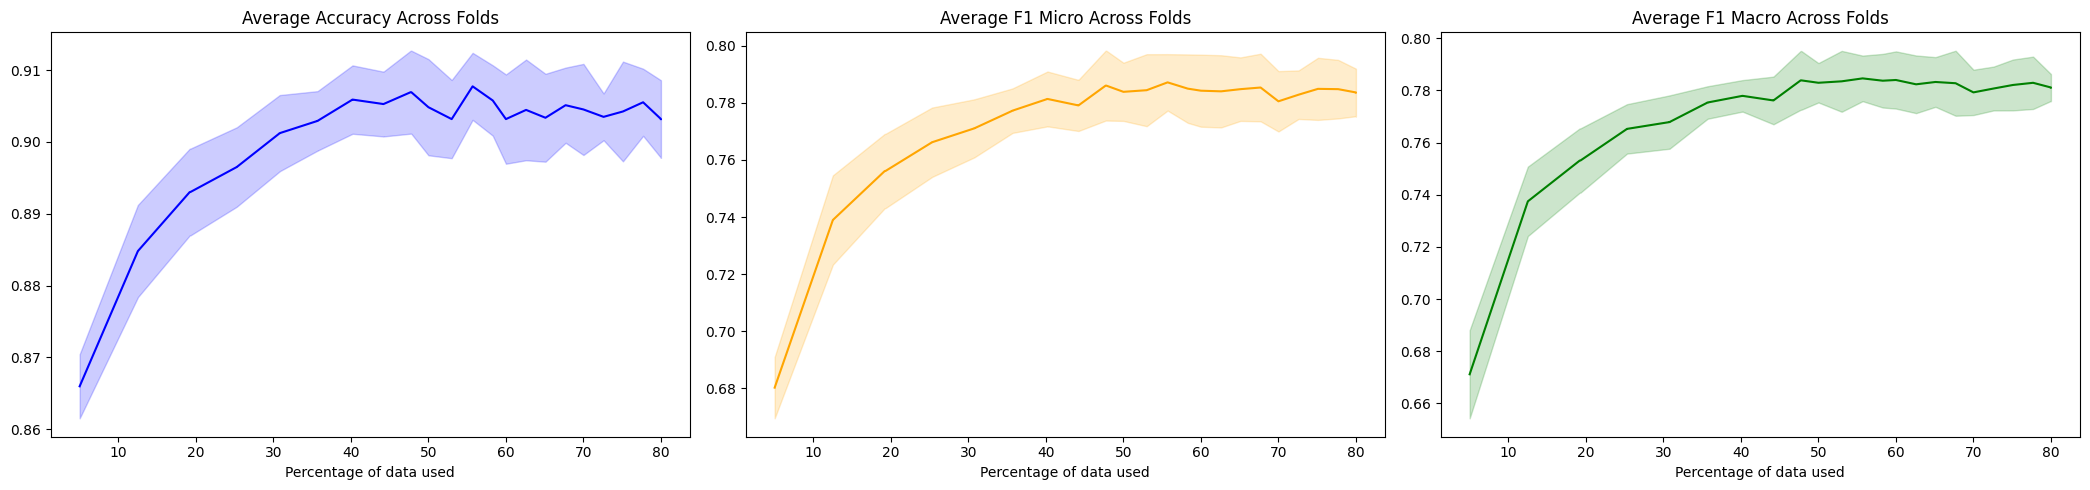

In [15]:
import matplotlib.pyplot as plt
import numpy as np

common_data_points = sorted(list(set(point for fold_points in all_fold_data_used for point in fold_points)))

# Interpolate metrics for each fold to the common data points
avg_accuracies = []
avg_f1_micros = []
avg_f1_macros = []
std_accuracies = []
std_f1_micros = []
std_f1_macros = []

for point in common_data_points:
    point_accuracies = []
    point_f1_micros = []
    point_f1_macros = []
    for i in range(N_SPLITS):
        sorted_indices = np.argsort(all_fold_data_used[i])
        sorted_data = np.array(all_fold_data_used[i])[sorted_indices]
        
        sorted_acc = np.array(all_fold_accuracies[i])[sorted_indices]
        sorted_f1m = np.array(all_fold_f1_micros[i])[sorted_indices]
        sorted_f1ma = np.array(all_fold_f1_macros[i])[sorted_indices]
        
        # Use interpolation to estimate the metric value at the common 'point'
        point_accuracies.append(np.interp(point, sorted_data, sorted_acc))
        point_f1_micros.append(np.interp(point, sorted_data, sorted_f1m))
        point_f1_macros.append(np.interp(point, sorted_data, sorted_f1ma))
    
    avg_accuracies.append(np.mean(point_accuracies))
    avg_f1_micros.append(np.mean(point_f1_micros))
    avg_f1_macros.append(np.mean(point_f1_macros))
    
    std_accuracies.append(np.std(point_accuracies))
    std_f1_micros.append(np.std(point_f1_micros))
    std_f1_macros.append(np.std(point_f1_macros))

# Convert to numpy arrays for easier plotting
avg_accuracies = np.array(avg_accuracies)
avg_f1_micros = np.array(avg_f1_micros)
avg_f1_macros = np.array(avg_f1_macros)
std_accuracies = np.array(std_accuracies)
std_f1_micros = np.array(std_f1_micros)
std_f1_macros = np.array(std_f1_macros)

fig, axs = plt.subplots(1, 3, figsize=(21, 5))
data_used_percent = [round(data / len(X) * 100, 1) for data in common_data_points]

# Plot for Accuracy
axs[0].plot(data_used_percent, avg_accuracies, label="Avg Accuracy", color="blue")
axs[0].fill_between(data_used_percent, avg_accuracies - std_accuracies, avg_accuracies + std_accuracies, color='blue', alpha=0.2)
axs[0].set_xlabel("Percentage of data used")
axs[0].set_title("Average Accuracy Across Folds")

# Plot for F1 Micro
axs[1].plot(data_used_percent, avg_f1_micros, label="Avg F1 Micro", color="orange")
axs[1].fill_between(data_used_percent, avg_f1_micros - std_f1_micros, avg_f1_micros + std_f1_micros, color='orange', alpha=0.2)
axs[1].set_xlabel("Percentage of data used")
axs[1].set_title("Average F1 Micro Across Folds")

# Plot for F1 Macro
axs[2].plot(data_used_percent, avg_f1_macros, label="Avg F1 Macro", color="green")
axs[2].fill_between(data_used_percent, avg_f1_macros - std_f1_macros, avg_f1_macros + std_f1_macros, color='green', alpha=0.2)
axs[2].set_xlabel("Percentage of data used")
axs[2].set_title("Average F1 Macro Across Folds")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

for i in range(N_SPLITS):
    result = pd.DataFrame({
        'Data Used': all_fold_data_used[i],
        'Accuracy': all_fold_accuracies[i],
        'F1 Micro': all_fold_f1_micros[i],
        'F1 Macro': all_fold_f1_macros[i],
    })

    result.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)